In [2]:
!pip install kmodes

from kmodes.kmodes import KModes
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import warnings
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

## Analysis of programmers density in Poland per Population and GDP

At previous stages of analysis we were able to identify most popular, and important programming hubs within Europe. We have answered a sequence of questions in terms of where and how technology affect the regions and which areas are more or less technology advanced.

On the next step we will dig deeper into how region in Europe are advanced in terms of programming, and how population that lives there are adjusting to the technology revolution over the past few years (2008-2020). To understand those changes and adaptiveness of the society we will investigate what is the density of the programmers per population and how those translates to the Gross Domestic Products of analyzed regions.

To answer this question, we need to establish criteria that define what constitutes a "programmers". Our database extracted from Stack Overflow contains the information about users' activity within those regions throughout the years, however each programmer is interacting with Stack Overflow more than once in their professional activity / lifetime, therefore this must be considered, while establishing the amount of programmers.

As said, our database consists data about user activity: number of questions asked, number of answers submitted, numbers of positive and negative interaction with a post and number of comments. All information are aggregated by year and by region (NUTS3). Based on those interactions with platform, it must be defined how ordinary programmers behaves, how often she/he interacts with platform, and in what way, in order to establish a definition of "programmer".

Here are some considerations and steps to approach this:

We supported ourselves with the data from research conducted by Stack Overflow among their users - **Stack Overflow Developers Survey 2021.** This dataset contains information about developers / programmers habits: how often they interact with platform, what is their profession, how frequently they visit the platform. This dataset will serve as basis to define definition of programmer based on their Stack OVerflow activity.

In [3]:
survey_data = pd.read_csv('Downloads/survey_results_public.csv')
survey_data.head(5)

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,NaN,NaN,"Secondary school (e.g. American high school, G...",18 - 24 years,Coding Bootcamp;Other online resources (ex: vi...,NaN,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",7,...,18-24 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",NaN,...,18-24 years old,Man,No,Prefer not to say,Prefer not to say,None of the above,None of the above,Appropriate in length,Easy,NaN
3,4,I am a developer by profession,Employed full-time,Austria,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",11 - 17 years,NaN,NaN,...,35-44 years old,Man,No,Straight / Heterosexual,White or of European descent,I am deaf / hard of hearing,NaN,Appropriate in length,Neither easy nor difficult,NaN
4,5,I am a developer by profession,"Independent contractor, freelancer, or self-em...",United Kingdom of Great Britain and Northern I...,NaN,England,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5 - 10 years,Friend or family member,17,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,NaN,Appropriate in length,Easy,NaN


In [4]:
PL_data = survey_data[survey_data["Country"] == "Poland"]
PL_data

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly
32,33,I am a developer by profession,"Not employed, but looking for work",Poland,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",11 - 17 years,School,8,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,I have an anxiety disorder,Appropriate in length,Easy,NaN
76,77,"I am not primarily a developer, but I write co...",Employed full-time,Poland,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",12,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,45564.0
97,98,I am a developer by profession,Employed full-time,Poland,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",10,...,18-24 years old,Man,No,Gay or Lesbian,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,27336.0
115,116,I am a student who is learning to code,"Student, full-time",Poland,NaN,NaN,"Secondary school (e.g. American high school, G...",5 - 10 years,Other (please specify):,4,...,Under 18 years old,Man,No,Straight / Heterosexual,White or of European descent,NaN,I have a concentration and/or memory disorder ...,Appropriate in length,Easy,NaN
138,139,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Poland,NaN,NaN,Some college/university study without earning ...,18 - 24 years,Online Forum,5,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent;Middle Eastern,None of the above,None of the above,Appropriate in length,Neither easy nor difficult,48600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83110,83111,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Poland,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",10,...,25-34 years old,Man,NaN,NaN,NaN,NaN,NaN,Too long,NaN,NaN
83145,83146,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Poland,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",18 - 24 years,Coding Bootcamp;School;Online Courses or Certi...,10,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,72900.0
83203,83204,I am a developer by profession,Employed full-time,Poland,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5 - 10 years,Other (please specify):;Books / Physical media,25,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,44040.0
83264,83265,"I am not primarily a developer, but I write co...","Student, full-time",Poland,NaN,NaN,Primary/elementary school,11 - 17 years,"Other online resources (ex: videos, blogs, etc...",4,...,Under 18 years old,Man,No,Prefer not to say,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,NaN


In [5]:
columns_to_drop = ["US_State", "UK_Country", "Age1stCode", "LearnCode", "YearsCode", "Gender", "Trans", "Sexuality", 
                  "Ethnicity", "Accessibility", "MentalHealth", 'YearsCodePro', 'DevType', 'OrgSize', 'Currency', 'CompTotal',
                    'CompFreq', 'LanguageHaveWorkedWith', 'LanguageWantToWorkWith','DatabaseHaveWorkedWith', 
                    'DatabaseWantToWorkWith','PlatformHaveWorkedWith', 'PlatformWantToWorkWith','WebframeHaveWorkedWith', 
                    'WebframeWantToWorkWith','MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith','ToolsTechHaveWorkedWith', 
                    'ToolsTechWantToWorkWith','NEWCollabToolsHaveWorkedWith', 'NEWCollabToolsWantToWorkWith', 'OpSys',
                    "SurveyLength", "SurveyEase", "ConvertedCompYearly"]
PL_data = PL_data.drop(columns = columns_to_drop)
PL_data = PL_data[PL_data['SOPartFreq'].notna()]

In [6]:
PL_data.MainBranch.value_counts()

I am a developer by profession                                                   1048
I am a student who is learning to code                                            190
I am not primarily a developer, but I write code sometimes as part of my work     102
I code primarily as a hobby                                                        81
I used to be a developer by profession, but no longer am                           10
None of these                                                                       8
Name: MainBranch, dtype: int64

In [7]:
PL_data.SOPartFreq.value_counts()

Less than once per month or monthly                   697
I have never participated in Q&A on Stack Overflow    371
A few times per month or weekly                       250
A few times per week                                   82
Daily or almost daily                                  24
Multiple times per day                                 15
Name: SOPartFreq, dtype: int64

In [8]:
# Count the occurrences of each combination
combination_counts = PL_data.groupby(['MainBranch', 'SOPartFreq']).size().reset_index(name='Count')

# Display the result
combination_counts = PL_data.groupby(['MainBranch', 'SOPartFreq']).size().reset_index(name='Count')

# Sort the values in ascending order
combination_counts = combination_counts.sort_values(by=['MainBranch', 'SOPartFreq'], ascending= True)

# Calculate the ratio for each category
combination_counts['Ratio'] = combination_counts['Count'] / combination_counts['Count'].sum()

combination_counts

,MainBranch,SOPartFreq,Count,Ratio
0,I am a developer by profession,A few times per month or weekly,180,0.125087
1,I am a developer by profession,A few times per week,64,0.044475
2,I am a developer by profession,Daily or almost daily,17,0.011814
3,I am a developer by profession,I have never participated in Q&A on Stack Over...,236,0.164003
4,I am a developer by profession,Less than once per month or monthly,541,0.375956
5,I am a developer by profession,Multiple times per day,10,0.006949
6,I am a student who is learning to code,A few times per month or weekly,29,0.020153
7,I am a student who is learning to code,A few times per week,7,0.004864
8,I am a student who is learning to code,Daily or almost daily,3,0.002085
9,I am a student who is learning to code,I have never participated in Q&A on Stack Over...,75,0.052120


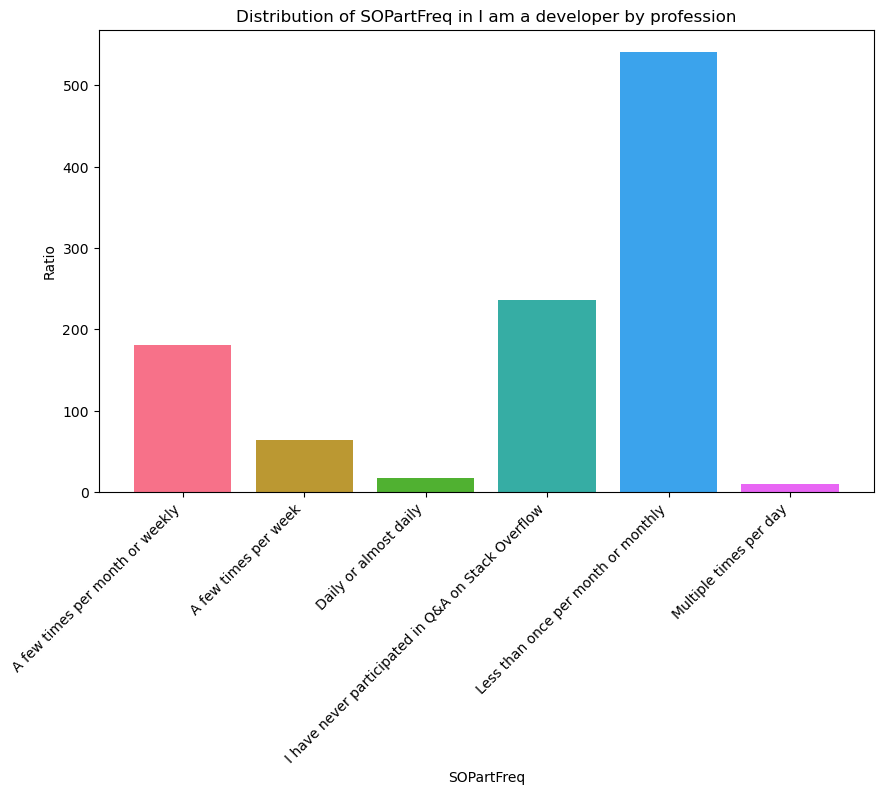

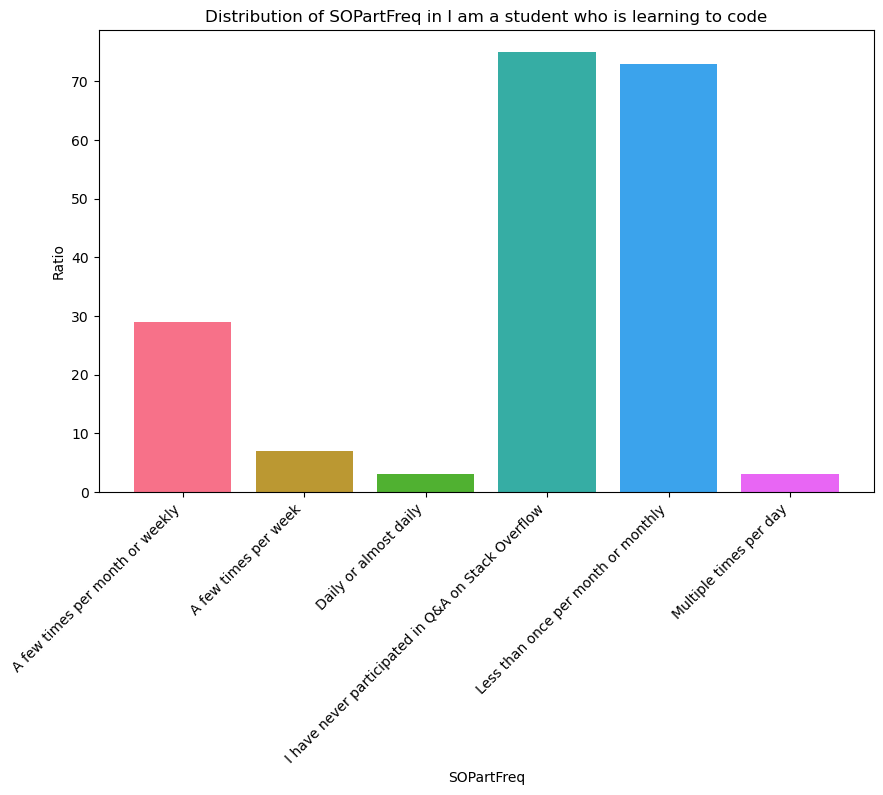

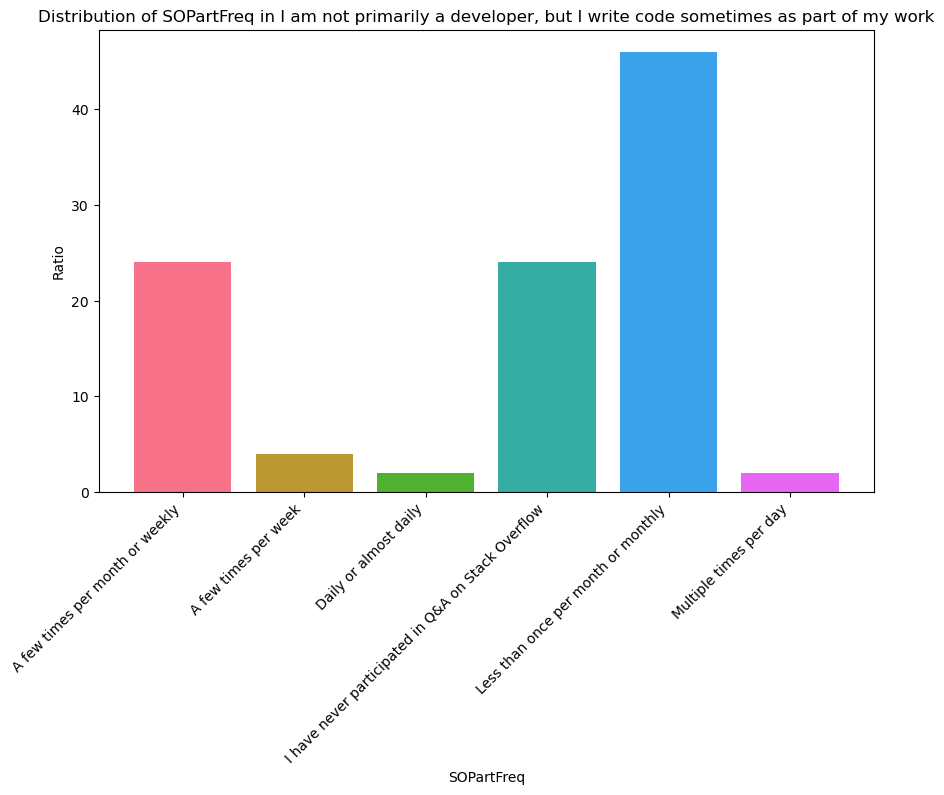

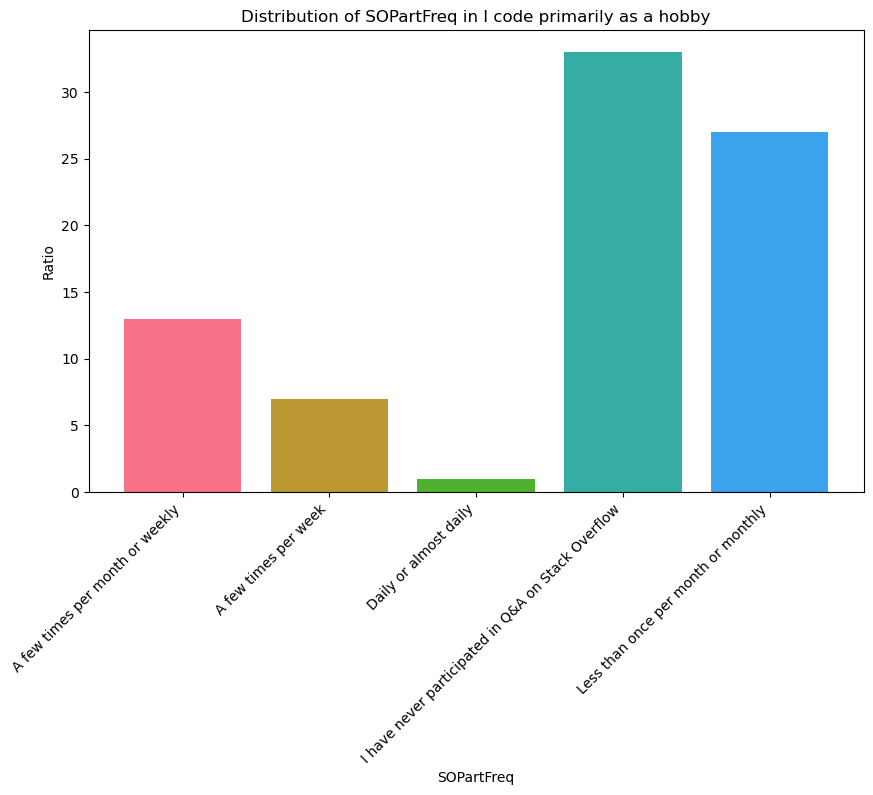

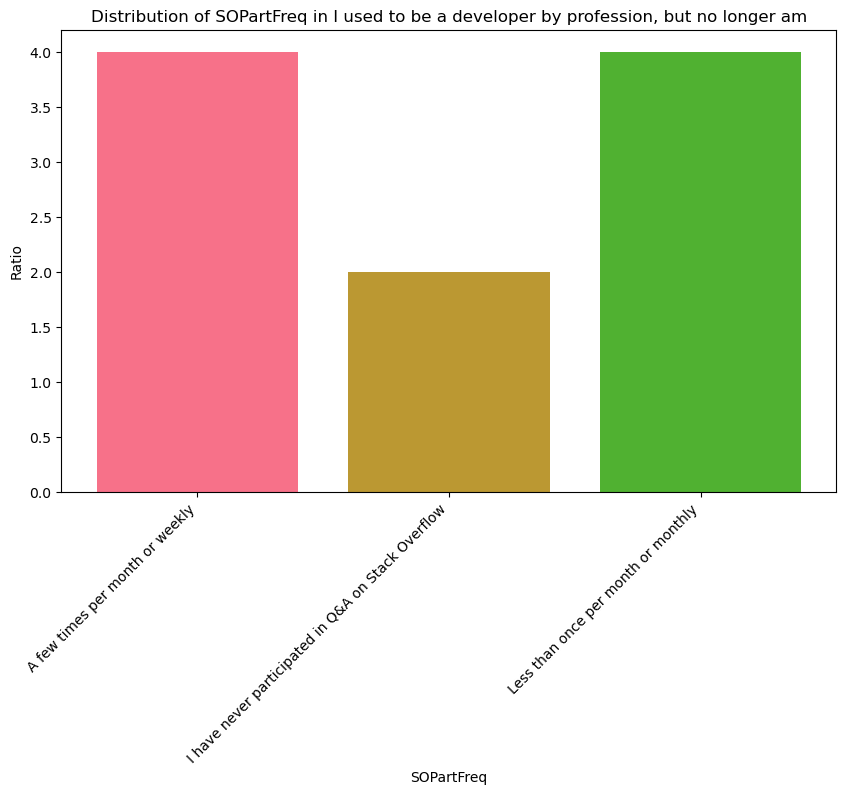

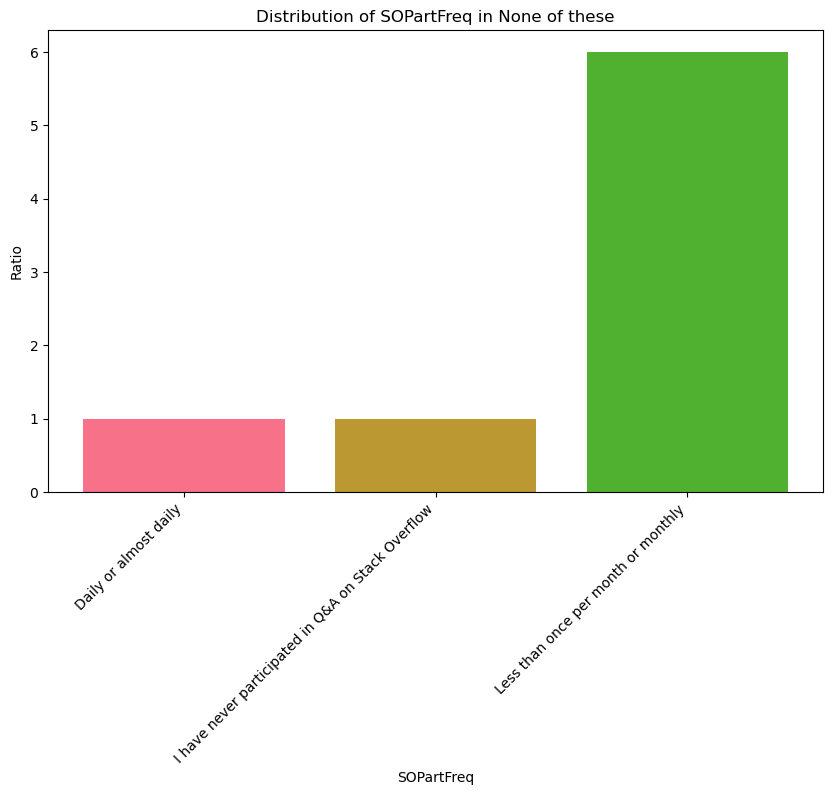

In [9]:
# Visualize the results with different colors for each bar
categories = combination_counts['MainBranch'].unique()
colors = sns.color_palette("husl", n_colors=len(combination_counts['SOPartFreq'].unique()))

for category in categories:
    category_data = combination_counts[combination_counts['MainBranch'] == category]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(category_data['SOPartFreq'], category_data['Count'], color=colors)
    plt.title(f'Distribution of SOPartFreq in {category}')
    plt.xlabel('SOPartFreq')
    plt.ylabel('Ratio')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

    plt.show()

To interpret and draw conclusions from the provided data, let's analyze the patterns and identify potential personas. The table seems to represent the frequency of participation on Stack Overflow based on the main professional branches of the respondents.

**Interpretation:**

1. Developers by Profession:
 - The majority participate in Q&A a few times per month or weekly.
 - A significant portion engages a few times per week.
 - Daily participation is less common.
 - A substantial number have never participated or participate less frequently.

2. Students Learning to Code:
- Similar to developers, the majority participate a few times per month or weekly.
- A lower number engage daily.
- A significant proportion has never participated or participates less frequently.

3. Non-Developer Coders:
- Engagement is generally lower than developers and students.
- Most participate a few times per month or weekly.
- Daily participation is minimal.
- A portion has never participated or participates less frequently.

4. Hobbyist Coders:
- Participation is lower overall.
- A few times per month or weekly is the most common frequency.
- Daily participation is very rare.
- Some have never participated or participate less frequently.

The rest of the groups stands for the smallest portion of answers, so for the similicipy of analysis we will not include them and attach them to the group Hobbyist Coders. 

**Conclusion:**

1. Frequency Trends: A pattern emerges across all professional branches where a few times per month or weekly is the most common participation frequency.
2. Engagement Levels: Developers and students are more actively engaged compared to hobbyists, non-developers, former developers, and those who selected "None of these."


**Further Analysis:**

As a next step we should utilize **K-modes clustering** to statistically define personas based on different attributes like technology stack, years of experience, or specific programming languages. By implementing a more detailed analysis using clustering techniques, you can gain insights into the diverse behaviors within each professional branch and create a more personalized experience for Stack Overflow users.

### Clustering programmers

**Clustering as a way of creating personas:**

Clustering is a technique used in data analysis and machine learning to group similar data points together based on certain characteristics or features. The primary goal of clustering is to discover inherent patterns or structures within the data, making it easier to understand and interpret complex datasets.

Clustering can be particularly useful in scenarios where there is no predefined label for the data, and the objective is to uncover natural groupings or categories. In the context of your analysis, you are using clustering to define specific personas or sets of characteristics within your dataset.

There are different clustering algorithms, and two common ones are K-means clustering and K-modes clustering. Let's discuss the differences and why K-modes clustering might be more suitable for your analysis:

K-modes Clustering:

Data Type Requirement: K-modes is designed for categorical data. It works with modes (most frequent values) instead of means. Calculation Method: It employs a dissimilarity measure specifically tailored for categorical data, which considers the number of matching categories between data points. Why K-modes Clustering for Categorical Data:

Interpretability: Categorical data often represents qualitative attributes, and finding modes (most frequent values) is more interpretable than calculating means. Handling Missing Data: K-modes is more robust when dealing with missing categorical values compared to K-means. Nominal Data: K-modes is suitable for nominal data, where the order of categories doesn't matter, unlike K-means which assumes ordinality. In your analysis, where you are dealing with categorical data such as 'MainBranch' and 'SOPartFreq', K-modes clustering is a more appropriate choice. It allows you to group similar respondents based on categorical features, providing insights into patterns or personas that may exist within your dataset. The elbow test helps determine the optimal number of clusters for your specific data, enhancing the quality and relevance of the insights gained from the analysis.

In [10]:
most_popular_combinations = combination_counts.sort_values(by='Ratio', ascending=False)
most_popular_combinations.head(10)

,MainBranch,SOPartFreq,Count,Ratio
4,I am a developer by profession,Less than once per month or monthly,541,0.375956
3,I am a developer by profession,I have never participated in Q&A on Stack Over...,236,0.164003
0,I am a developer by profession,A few times per month or weekly,180,0.125087
9,I am a student who is learning to code,I have never participated in Q&A on Stack Over...,75,0.052120
10,I am a student who is learning to code,Less than once per month or monthly,73,0.050730
1,I am a developer by profession,A few times per week,64,0.044475
16,"I am not primarily a developer, but I write co...",Less than once per month or monthly,46,0.031967
21,I code primarily as a hobby,I have never participated in Q&A on Stack Over...,33,0.022933
6,I am a student who is learning to code,A few times per month or weekly,29,0.020153
22,I code primarily as a hobby,Less than once per month or monthly,27,0.018763


In [11]:
most_popular_combinations.shape

(29, 4)

In [12]:
person = ['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','P11','P12','P13','P14','P15','P16',
         'P17','P18','P19','P20','P21','P22','P23','P24','P25','P26','P27','P28','P29']
most_popular_combinations["person"] = person
data_cluster = most_popular_combinations.set_index('person')
data_cluster

,MainBranch,SOPartFreq,Count,Ratio
person,,,,
P1,I am a developer by profession,Less than once per month or monthly,541,0.375956
P2,I am a developer by profession,I have never participated in Q&A on Stack Over...,236,0.164003
P3,I am a developer by profession,A few times per month or weekly,180,0.125087
P4,I am a student who is learning to code,I have never participated in Q&A on Stack Over...,75,0.052120
P5,I am a student who is learning to code,Less than once per month or monthly,73,0.050730
P6,I am a developer by profession,A few times per week,64,0.044475
P7,"I am not primarily a developer, but I write co...",Less than once per month or monthly,46,0.031967
P8,I code primarily as a hobby,I have never participated in Q&A on Stack Over...,33,0.022933
P9,I am a student who is learning to code,A few times per month or weekly,29,0.020153


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 98.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 98.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 98.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 98.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 98.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4, cost: 85.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 3, cost: 84.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration

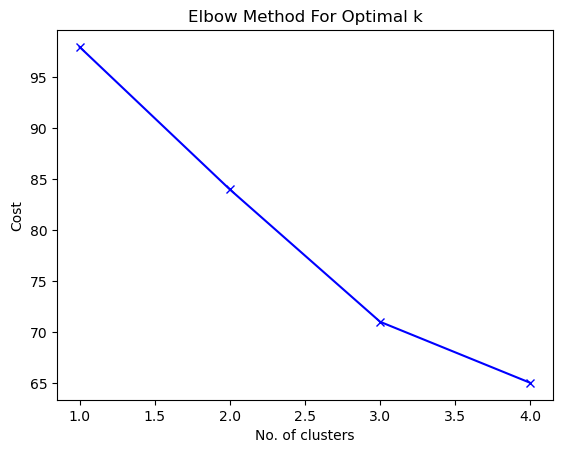

In [13]:
data_cluster_copy = data_cluster.copy()

# Elbow curve to find optimal K
cost = []
K = range(1,5)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(data_cluster_copy)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [14]:
kmode = KModes(n_clusters=3, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(data_cluster_copy)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4, cost: 75.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 4, cost: 77.0
Run 2, iteration: 2/100, moves: 1, cost: 77.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 6, cost: 77.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 3, cost: 73.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 4, cost: 74.0
Best run was number 4


array([1, 0, 1, 0, 1, 1, 1, 0, 2, 0, 0, 0, 1, 0, 1, 2, 0, 1, 1, 1, 1, 2,
       2, 0, 0, 2, 0, 0, 0], dtype=uint16)

In [15]:
data_cluster["Cluster"] = clusters
grouped_df = pd.DataFrame(columns=data_cluster.columns)
grouped = data_cluster.groupby("Cluster")

# Iterate over the groups and append each group to the new DataFrame
for name, group in grouped:
    grouped_df = pd.concat([grouped_df, group])

grouped_df.sort_values(by=['Cluster', 'MainBranch'])

,MainBranch,SOPartFreq,Count,Ratio,Cluster
P2,I am a developer by profession,I have never participated in Q&A on Stack Over...,236,0.164003,0
P4,I am a student who is learning to code,I have never participated in Q&A on Stack Over...,75,0.052120,0
P11,"I am not primarily a developer, but I write co...",A few times per month or weekly,24,0.016678,0
P12,"I am not primarily a developer, but I write co...",I have never participated in Q&A on Stack Over...,24,0.016678,0
P24,"I am not primarily a developer, but I write co...",Multiple times per day,2,0.001390,0
P8,I code primarily as a hobby,I have never participated in Q&A on Stack Over...,33,0.022933,0
P10,I code primarily as a hobby,Less than once per month or monthly,27,0.018763,0
P14,I code primarily as a hobby,A few times per month or weekly,13,0.009034,0
P17,I code primarily as a hobby,A few times per week,7,0.004864,0
P27,I code primarily as a hobby,Daily or almost daily,1,0.000695,0


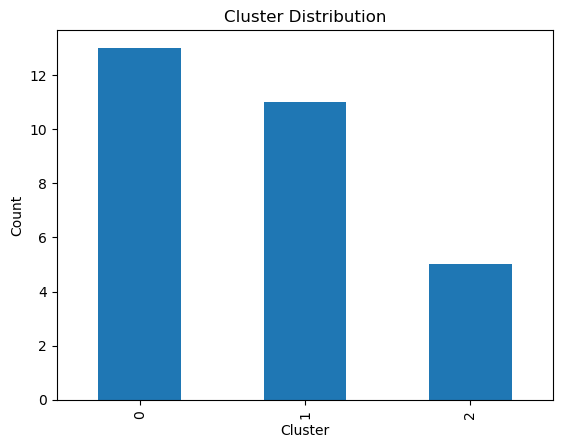

In [16]:
# Visualize the distribution of clusters
cluster_counts = data_cluster['Cluster'].value_counts()
cluster_counts.plot(kind='bar', xlabel='Cluster', ylabel='Count', title='Cluster Distribution')
plt.show()

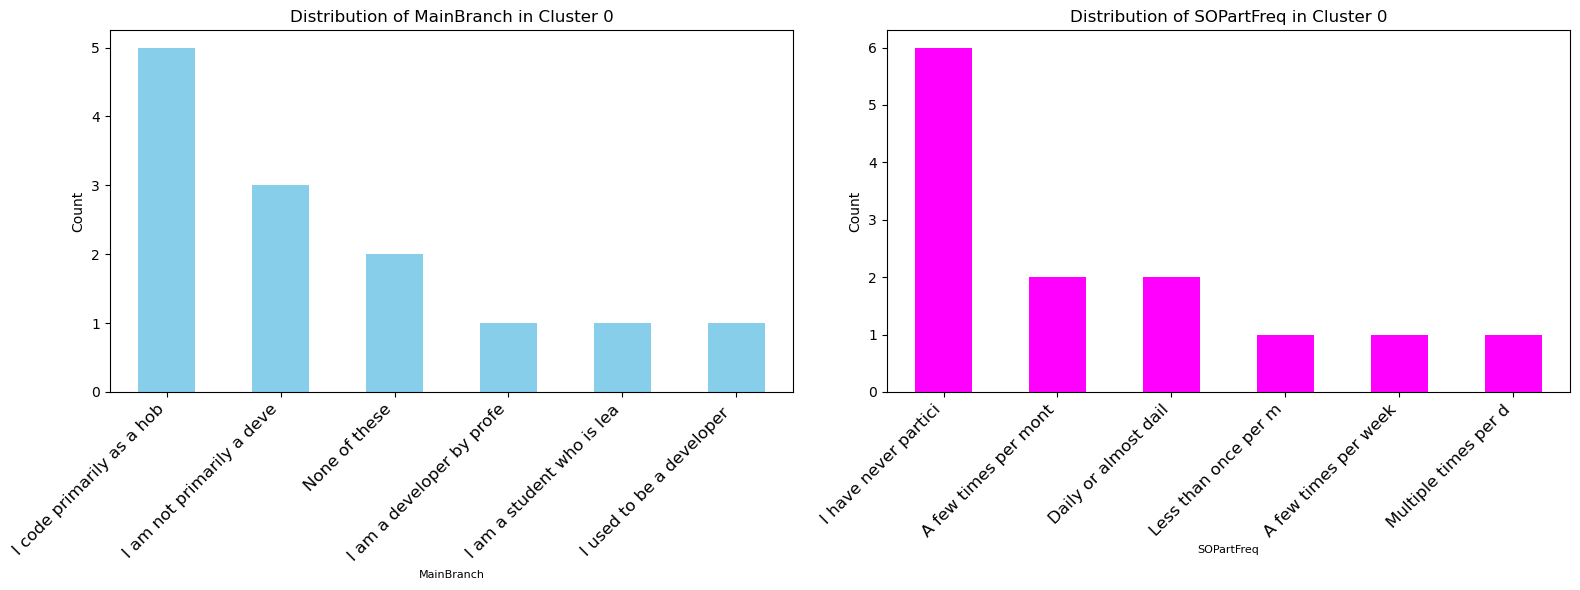

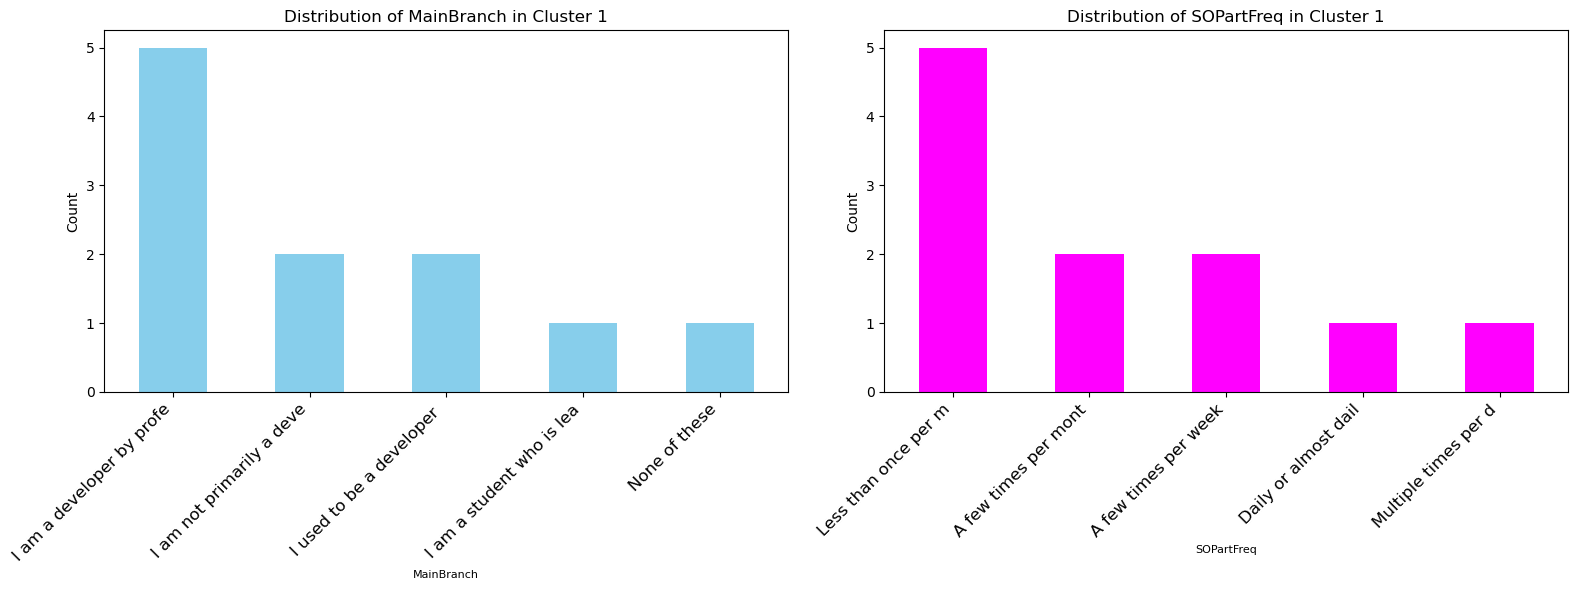

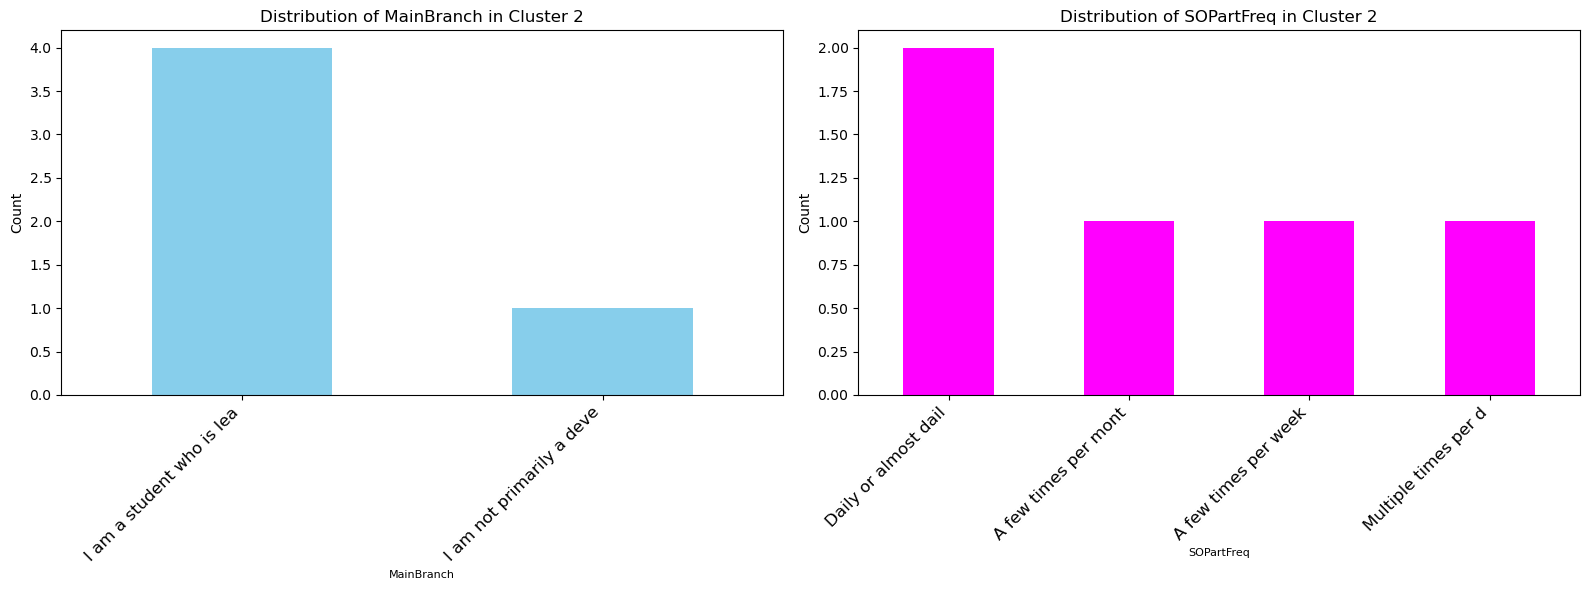

In [17]:
# Set the number of subplots per row
subplots_per_row = 2

# Categorical variable distribution for each cluster
for name, group in grouped_df.groupby("Cluster"):
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot MainBranch distribution
    axes[0].set_title(f'Distribution of MainBranch in Cluster {name}')
    main_branch_labels = [label[:25] for label in group['MainBranch'].value_counts().index]  # Display only the first 10 characters
    group['MainBranch'].value_counts().plot(kind='bar', color='skyblue', ax=axes[0])
    axes[0].set_xlabel('MainBranch', fontsize=8)
    axes[0].set_ylabel('Count')
    axes[0].set_xticklabels(main_branch_labels, rotation=45, ha='right', fontsize=12)  # Set rotation and font size
    
    # Plot SOPartFreq distribution
    axes[1].set_title(f'Distribution of SOPartFreq in Cluster {name}')
    sofreq_labels = [label[:20] for label in group['SOPartFreq'].value_counts().index]  # Display only the first 10 characters
    group['SOPartFreq'].value_counts().plot(kind='bar', color='magenta', ax=axes[1])
    axes[1].set_xlabel('SOPartFreq', fontsize=8)
    axes[1].set_ylabel('Count')
    axes[1].set_xticklabels(sofreq_labels, rotation=45, ha='right', fontsize=12)  # Set rotation and font size
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the subplots
    plt.show()


**Interpretation of Clustering Results:** 

The K-modes clustering methodology identified 3 clusters among the 36 different combinations of MainBranch and SOPartFreq. These clusters represent distinct groups or personas based on the respondents' behaviors related to their profession and frequency of participating in Stack Overflow discussions.

**Cluster 0:**

MainBranch: Primarily developers by profession.
SOPartFreq: Most respondents participate less frequently:
 - Less than once per month or monthly.
 - I have never participated in Q&A on Stack Overflow.
 - A few times per month or weekly.
Ratio: 72.99%

This cluster represents a diverse group of developers with varying levels of participation on Stack Overflow. The majority engage in Q&A activities infrequently.


**Cluster 1:**

MainBranch: Primarily developers, students learning to code, non-developers who write code, hobbyist coders, and former developers.
SOPartFreq: Predominantly participate less frequently:
 - Less than once per month or monthly.
 - I have never participated in Q&A on Stack Overflow.
 - A few times per month or weekly.
 - A few times per week.
Ratio: 12.70%

This cluster captures individuals across various professional branches who participate less frequently on Stack Overflow. It includes a mix of developers, students, non-developers, hobbyists, and former developers.


**Cluster 2:**

MainBranch: Primarily students learning to code and individuals coding primarily as a hobby.
SOPartFreq: Most respondents participate more frequently:
 - A few times per month or weekly.
 - A few times per week.
 - Multiple times per day.
Ratio: 2.92%

This cluster represents a smaller group of individuals, mainly students and hobbyist coders, who actively participate on Stack Overflow more frequently than the other clusters.

**Conclusion:**
The clustering has effectively grouped respondents into clusters based on their professional branch and participation frequency.
1. Cluster 0 represents a diverse group of developers with varying participation levels.
2. Cluster 1 includes individuals across different professional branches who participate less frequently.
3. Cluster 2 is a smaller group of actively engaged individuals, primarily students and hobbyist coders.

This clustering analysis provides insights into distinct user behavior patterns, enabling targeted strategies for user engagement and support on Stack Overflow.

## Data Cleaning 

Preparation of dataset with all the economical and social factors in order to analyze programming density and define a predictive model that will enable us prediction of programming activity based on the economical resiliance / growth of the region. 

In [18]:
path = os.path.join("Downloads/all_factors_nuts3.xlsx")

# Read the Excel file
nuts3_data = pd.read_excel(path)

# Display the first few rows
nuts3_data.head()

,Unnamed: 0.1,Unnamed: 0,NUTS3 CODE,TIME_PERIOD,POP (THS),EMP (THS),EUR_HAB,EUR_HAB_EU27_2020,MIO_EUR,MIO_NAC,...,GVA (MIO_EUR),GVA (MIO_NAC),Kod,Studenci do Ludności w wieku 19-24,population men,population women,Value,Studenci,population in cities in %,Tech Universities
0,0,0,PL213,2007,756.30,428.6,13200,54,9982.27,37769.90,...,8712.37,32965,11212100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,PL213,2008,756.40,428.6,15100,60,11393.55,40015.30,...,9939.92,34910,11212100000,"255,5",NaN,NaN,3259.63,NaN,NaN,45461.0
2,2,2,PL213,2009,761.42,428.6,12800,53,9755.34,42217.21,...,8659.07,37473,11212100000,"272,2",NaN,NaN,3423.56,NaN,NaN,46251.0
3,3,3,PL213,2010,757.11,428.6,14600,58,11017.52,44011.69,...,9594.71,38328,11212100000,"254,7",NaN,NaN,3543.43,NaN,NaN,48352.0
4,4,4,PL213,2011,758.21,433.6,15300,60,11581.62,47723.22,...,10093.43,41591,11212100000,"272,8",NaN,NaN,3722.48,NaN,NaN,50035.0


In [19]:
nuts3_data = nuts3_data.drop(columns = ["Unnamed: 0", "Unnamed: 0.1", "Kod", "population men", "population women"])
nuts3_data = nuts3_data.rename(columns = {"TIME_PERIOD":"Year", 
                                          "Studenci do Ludności w wieku 19-24":"students_19_24",
                                         "Studenci":"students",
                                         "Value":"mean_salary"})
nuts3_data

,NUTS3 CODE,Year,POP (THS),EMP (THS),EUR_HAB,EUR_HAB_EU27_2020,MIO_EUR,MIO_NAC,MIO_PPS_EU27_2020,PPS_EU27_2020_HAB,PPS_HAB_EU27_2020,GVA (MIO_EUR),GVA (MIO_NAC),students_19_24,mean_salary,students,population in cities in %,Tech Universities
0,PL213,2007,756.30,428.6,13200,54,9982.27,37769.90,16084.62,21300,87,8712.37,32965,NaN,NaN,NaN,NaN,NaN
1,PL213,2008,756.40,428.6,15100,60,11393.55,40015.30,16853.02,22300,88,9939.92,34910,"255,5",3259.63,NaN,NaN,45461.0
2,PL213,2009,761.42,428.6,12800,53,9755.34,42217.21,17053.12,22400,93,8659.07,37473,"272,2",3423.56,NaN,NaN,46251.0
3,PL213,2010,757.11,428.6,14600,58,11017.52,44011.69,18453.85,24400,98,9594.71,38328,"254,7",3543.43,NaN,NaN,48352.0
4,PL213,2011,758.21,433.6,15300,60,11581.62,47723.22,19738.61,26000,101,10093.43,41591,"272,8",3722.48,NaN,NaN,50035.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,PL926,2016,259.80,108.3,9800,35,2556.74,11155.56,4471.49,17200,61,2272.64,9916,"3,8",4111.52,718.0,45.59,0.0
1018,PL926,2017,259.70,107.8,10500,36,2739.42,11661.73,4595.52,17700,60,2425.65,10326,"5,5",4341.10,990.0,45.46,0.0
1019,PL926,2018,259.80,107.4,11000,36,2857.49,12177.18,4722.54,18200,60,2502.64,10665,"6,7",4582.52,1146.0,45.30,0.0
1020,PL926,2019,259.10,107.1,11700,37,3040.11,13065.19,5001.82,19300,62,2671.96,11483,"2,1",4902.14,344.0,45.20,NaN


In [20]:
path = os.path.join("Downloads/clean_mapping_pl.xlsx")

# Read the Excel file
mapping = pd.read_excel(path)

# Display the first few rows
mapping.head()

,Unnamed: 0,NUTS1,NUTS1 CODE,NUTS2,NUTS2 CODE,NUTS3,NUTS3 CODE
0,0,MAKROREGION PÓŁNOCNY,PL6,REGION KUJAWSKO-POMORSKIE,PL61,PODREGION WROCŁAWSKI,PL619
1,1,MAKROREGION WSCHODNI,PL8,REGION PODLASKIE,PL84,PODREGION SUWALSKI,PL843
2,2,MAKROREGION PÓŁNOCNY,PL6,REGION WARMIŃSKO-MAZURSKIE,PL62,PODREGION OLSZYŃSKI,PL622
3,3,MAKROREGION POŁUDNIOWY,PL2,REGION ŚLĄSKIE,PL22,PODREGION SOSNOWIECKI,PL22B
4,4,MAKROREGION CENTRALNY,PL7,REGION ŁÓDZKIE,PL71,PODREGION PIOTRKOWSKI,PL713


In [21]:
final_pl = nuts3_data.merge(mapping[["NUTS3 CODE", "NUTS3"]], on = "NUTS3 CODE", how = "left")

column_order = ['Year', 'NUTS3', 'NUTS3 CODE'] + \
               [col for col in final_pl.columns if col not in ['Year', 'NUTS3', 'NUTS3 CODE']]
final_pl = final_pl[column_order]

final_pl["NUTS3"] = final_pl["NUTS3"].str.replace("PODREGION ", '', case=False)
final_pl["NUTS3"] = final_pl["NUTS3"].str.replace("MIASTO ", '', case=False)

final_pl

,Year,NUTS3,NUTS3 CODE,POP (THS),EMP (THS),EUR_HAB,EUR_HAB_EU27_2020,MIO_EUR,MIO_NAC,MIO_PPS_EU27_2020,PPS_EU27_2020_HAB,PPS_HAB_EU27_2020,GVA (MIO_EUR),GVA (MIO_NAC),students_19_24,mean_salary,students,population in cities in %,Tech Universities
0,2007,KRAKÓW,PL213,756.30,428.6,13200,54,9982.27,37769.90,16084.62,21300,87,8712.37,32965,NaN,NaN,NaN,NaN,NaN
1,2008,KRAKÓW,PL213,756.40,428.6,15100,60,11393.55,40015.30,16853.02,22300,88,9939.92,34910,"255,5",3259.63,NaN,NaN,45461.0
2,2009,KRAKÓW,PL213,761.42,428.6,12800,53,9755.34,42217.21,17053.12,22400,93,8659.07,37473,"272,2",3423.56,NaN,NaN,46251.0
3,2010,KRAKÓW,PL213,757.11,428.6,14600,58,11017.52,44011.69,18453.85,24400,98,9594.71,38328,"254,7",3543.43,NaN,NaN,48352.0
4,2011,KRAKÓW,PL213,758.21,433.6,15300,60,11581.62,47723.22,19738.61,26000,101,10093.43,41591,"272,8",3722.48,NaN,NaN,50035.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,2016,ŻYRARDOWSKI,PL926,259.80,108.3,9800,35,2556.74,11155.56,4471.49,17200,61,2272.64,9916,"3,8",4111.52,718.0,45.59,0.0
1018,2017,ŻYRARDOWSKI,PL926,259.70,107.8,10500,36,2739.42,11661.73,4595.52,17700,60,2425.65,10326,"5,5",4341.10,990.0,45.46,0.0
1019,2018,ŻYRARDOWSKI,PL926,259.80,107.4,11000,36,2857.49,12177.18,4722.54,18200,60,2502.64,10665,"6,7",4582.52,1146.0,45.30,0.0
1020,2019,ŻYRARDOWSKI,PL926,259.10,107.1,11700,37,3040.11,13065.19,5001.82,19300,62,2671.96,11483,"2,1",4902.14,344.0,45.20,NaN


In [22]:
file_path = 'Downloads/PLdata_Chris.dta'
df_so = pd.read_stata(file_path)

# Extract year and quarter, and convert to datetime
df_so['Year'] = df_so['Quarter'].str.extract(r'(\d{4})')  # Extract the year
df_so = df_so.drop(columns = ["Quarter"])

#clean the table before the merge
result = df_so.groupby(['NUTS3CODE', 'Year'])['questioncount', 'answercount'].sum().reset_index()
result['Year'] = result['Year'].astype('int64')
result = result.rename(columns = {"NUTS3CODE":"NUTS3 CODE"})

final_pl = result.merge(final_pl, on = ["NUTS3 CODE", 'Year'], how = "left")
final_pl

,NUTS3 CODE,Year,questioncount,answercount,NUTS3,POP (THS),EMP (THS),EUR_HAB,EUR_HAB_EU27_2020,MIO_EUR,...,MIO_PPS_EU27_2020,PPS_EU27_2020_HAB,PPS_HAB_EU27_2020,GVA (MIO_EUR),GVA (MIO_NAC),students_19_24,mean_salary,students,population in cities in %,Tech Universities
0,PL214,2008,26.0,108.0,KRAKOWSKI,670.50,228.6,6900.0,27.0,4618.78,...,6831.97,10200.0,40.0,4029.50,14152.0,"1,5",2700.24,NaN,NaN,NaN
1,PL214,2009,74.0,218.0,KRAKOWSKI,682.14,228.6,5800.0,24.0,3935.93,...,6880.32,10100.0,42.0,3493.62,15119.0,"2,2",2853.76,NaN,NaN,NaN
2,PL214,2010,203.0,466.0,KRAKOWSKI,689.31,228.6,6400.0,26.0,4402.10,...,7373.32,10700.0,43.0,3910.93,15623.0,"2,5",3007.55,NaN,NaN,NaN
3,PL214,2011,715.0,830.0,KRAKOWSKI,694.91,235.1,6900.0,27.0,4817.08,...,8209.78,11800.0,46.0,4256.42,17539.0,"2,5",3169.45,NaN,NaN,NaN
4,PL214,2012,825.0,1062.0,KRAKOWSKI,700.50,233.8,7100.0,28.0,4978.49,...,8564.19,12200.0,47.0,4433.77,18554.0,"2,2",3297.54,1338.0,22.86,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,PL926,2017,306.0,205.0,ŻYRARDOWSKI,259.70,107.8,10500.0,36.0,2739.42,...,4595.52,17700.0,60.0,2425.65,10326.0,"5,5",4341.10,990.0,45.46,0.0
977,PL926,2018,220.0,98.0,ŻYRARDOWSKI,259.80,107.4,11000.0,36.0,2857.49,...,4722.54,18200.0,60.0,2502.64,10665.0,"6,7",4582.52,1146.0,45.30,0.0
978,PL926,2019,246.0,452.0,ŻYRARDOWSKI,259.10,107.1,11700.0,37.0,3040.11,...,5001.82,19300.0,62.0,2671.96,11483.0,"2,1",4902.14,344.0,45.20,NaN
979,PL926,2020,279.0,226.0,ŻYRARDOWSKI,258.80,107.8,12000.0,40.0,3093.94,...,5155.48,19900.0,66.0,2725.19,12108.0,"7,2",5319.27,1129.0,44.60,NaN


In [23]:
final_pl = final_pl[(final_pl["Year"] > 2011) & (final_pl["Year"] < 2021)]
final_pl

,NUTS3 CODE,Year,questioncount,answercount,NUTS3,POP (THS),EMP (THS),EUR_HAB,EUR_HAB_EU27_2020,MIO_EUR,...,MIO_PPS_EU27_2020,PPS_EU27_2020_HAB,PPS_HAB_EU27_2020,GVA (MIO_EUR),GVA (MIO_NAC),students_19_24,mean_salary,students,population in cities in %,Tech Universities
4,PL214,2012,825.0,1062.0,KRAKOWSKI,700.50,233.8,7100.0,28.0,4978.49,...,8564.19,12200.0,47.0,4433.77,18554.0,"2,2",3297.54,1338.0,22.86,NaN
5,PL214,2013,1109.0,1631.0,KRAKOWSKI,705.49,235.1,7200.0,28.0,5097.10,...,8762.15,12400.0,48.0,4517.93,18964.0,"2,4",3436.01,1423.0,22.78,NaN
6,PL214,2014,1803.0,1809.0,KRAKOWSKI,710.20,239.6,7600.0,29.0,5412.74,...,9184.36,12900.0,49.0,4859.59,20334.0,"2,4",3552.25,1432.0,22.72,NaN
7,PL214,2015,1371.0,1930.0,KRAKOWSKI,713.71,250.4,8300.0,30.0,5951.14,...,10140.94,14200.0,52.0,5320.38,22261.0,"2,1",3775.55,1216.0,22.67,NaN
8,PL214,2016,1663.0,2472.0,KRAKOWSKI,718.10,255.6,8400.0,30.0,6048.46,...,10578.17,14700.0,52.0,5374.72,23451.0,"2,0",4009.95,1117.0,22.65,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,PL926,2016,520.0,391.0,ŻYRARDOWSKI,259.80,108.3,9800.0,35.0,2556.74,...,4471.49,17200.0,61.0,2272.64,9916.0,"3,8",4111.52,718.0,45.59,0.0
976,PL926,2017,306.0,205.0,ŻYRARDOWSKI,259.70,107.8,10500.0,36.0,2739.42,...,4595.52,17700.0,60.0,2425.65,10326.0,"5,5",4341.10,990.0,45.46,0.0
977,PL926,2018,220.0,98.0,ŻYRARDOWSKI,259.80,107.4,11000.0,36.0,2857.49,...,4722.54,18200.0,60.0,2502.64,10665.0,"6,7",4582.52,1146.0,45.30,0.0
978,PL926,2019,246.0,452.0,ŻYRARDOWSKI,259.10,107.1,11700.0,37.0,3040.11,...,5001.82,19300.0,62.0,2671.96,11483.0,"2,1",4902.14,344.0,45.20,NaN


In [24]:
final_pl.isna().sum()

NUTS3 CODE                     0
Year                           0
questioncount                  0
answercount                    0
NUTS3                          0
POP (THS)                      0
EMP (THS)                      0
EUR_HAB                        0
EUR_HAB_EU27_2020              0
MIO_EUR                        0
MIO_NAC                        0
MIO_PPS_EU27_2020              0
PPS_EU27_2020_HAB              0
PPS_HAB_EU27_2020              0
GVA (MIO_EUR)                  0
GVA (MIO_NAC)                  0
students_19_24                 0
mean_salary                    0
students                       0
population in cities in %      0
Tech Universities            345
dtype: int64

In [25]:
final_pl['Tech Universities'].fillna(0, inplace=True)

In [26]:
final_pl.isna().sum()

NUTS3 CODE                   0
Year                         0
questioncount                0
answercount                  0
NUTS3                        0
POP (THS)                    0
EMP (THS)                    0
EUR_HAB                      0
EUR_HAB_EU27_2020            0
MIO_EUR                      0
MIO_NAC                      0
MIO_PPS_EU27_2020            0
PPS_EU27_2020_HAB            0
PPS_HAB_EU27_2020            0
GVA (MIO_EUR)                0
GVA (MIO_NAC)                0
students_19_24               0
mean_salary                  0
students                     0
population in cities in %    0
Tech Universities            0
dtype: int64

We have cleaned the dataset for the analysis and prediction purposes. 

## Short Analysis of top locations

### DEFINITION OF PROGRAMMER BASED ON THE STACK OVERFLOW DATA 

Based on the conducted analysis of Stack Overflow users' habits we can define 3 the most common behaviors, that we can group into specific personas. In this context, we understands a persona, as a collection of characteristics and behaviour that can be grouped and described as a specific user. Persona is a user with specifc habits, platform activity and characterstic. 

1. Cluster 0 represents a diverse group of developers with varying participation levels.
2. Cluster 1 includes individuals across different professional branches who participate less frequently.
3. Cluster 2 is a smaller group of actively engaged individuals, primarily students and hobbyist coders.

Based on analysis conducted with the help of Stack Overflow Developers Survey, we were able to distinguish three programmers personas. Each of them are type of programmer, but has different habits and behaviours related to usage and acitivty on Stack Overflow disucssion. 
To map them correctly we need to define what are similarities and differences between then, and how data that we have collected may help them distinguish them in out default dataset. 

We have defined three different personas: 

1. **Expert** 
 - They are profesional developers. Answers the questions and participare in discussion. They are knowledgable and experienced. 
 - Low activity - they participate in Stack Overflow discussion only occasionally. 
 - Highest portion of the Stack Overflow Users landscape in Poland. 
 
2. **Observer** 
 - They are not professionals programmers but they can code, and they use it for their job if needed. They do not usually participate in the discussion at any stages. 
 - Very low activity - they participate usually don't participate in the discussion. 
 - Smaller portion of the Stack Overflow users. 
 
3. **Learner** 
 - Those are the learners, beginning developers or students. They are asking questions to find out solutions to their problems.
 - Medium to high activity. They participate almost daily in the discussion and interact with users.
 - Very small partion of the users. 

Now, as we have defined successfully our programmers personas, we should try to translate them into our original dataset to estimate a number or Programmers in the NUTS3 regions based on the Stack Overflow Activity Data. 

To achieve that we should focus on type of activities that we are recording and define for each one of them how it should be treated in order to present in a best way, reality and estimate the number of programmers. 

##### Experts

- **answercount**: this variable define "Experts". The dataset contains data aggregated by year, therefore we should account for                    that. Regarding to the data from SO Survey from 2021. Experts are participating in SO discussions usually                        monthly. Hence to define how many experts are located in the specific NUTS region, we should divide total                        answer count in a region per 12 months, and multiple by 8 (as a equivalent of "few times per week"). This                        will give us final number of Experts in this NUTS3 Region. 


##### Observer 

- they don't usually participate in the Stack Overflow discussion. Therefore, it is almost impossible to match them with any of our variables, as those presents only the participation in Stack Overflow disucssion. For the sake of further analysis we will not include them as a persona, as they are only a small portion of the whole user base - 10%. 

##### Late Adopters 

- **questioncount**: those variables define "Late Adopters". Those are early developers or students who are learning to code.                        Those users are not participating very frequently, usually weekly.  Hence to define how many innovators are                      located in the specific NUTS region, we should divide total question count in a region per 12 months and                        multiple by 15 times (as a equivalent of "almost daily"). This will give us final number of Experts in this                      NUTS3 Region.  
              

In [27]:
#Defining number of programmers in each region based on the assumption made

weeks_in_year = 52
months_in_year = 12

#Experts in Region 
final_pl["Experts"] = final_pl["answercount"] / months_in_year

#Innovators in Region
final_pl["Learners"] = (final_pl["questioncount"] / months_in_year) * 4

#Delete unnecessary columns and sum up all Developers
final_pl.drop(columns = ["answercount", "questioncount"])
final_pl["Programmers_Total"] = final_pl["Experts"] + final_pl["Learners"]

final_pl

,NUTS3 CODE,Year,questioncount,answercount,NUTS3,POP (THS),EMP (THS),EUR_HAB,EUR_HAB_EU27_2020,MIO_EUR,...,GVA (MIO_EUR),GVA (MIO_NAC),students_19_24,mean_salary,students,population in cities in %,Tech Universities,Experts,Learners,Programmers_Total
4,PL214,2012,825.0,1062.0,KRAKOWSKI,700.50,233.8,7100.0,28.0,4978.49,...,4433.77,18554.0,"2,2",3297.54,1338.0,22.86,0.0,88.500000,275.000000,363.500000
5,PL214,2013,1109.0,1631.0,KRAKOWSKI,705.49,235.1,7200.0,28.0,5097.10,...,4517.93,18964.0,"2,4",3436.01,1423.0,22.78,0.0,135.916667,369.666667,505.583333
6,PL214,2014,1803.0,1809.0,KRAKOWSKI,710.20,239.6,7600.0,29.0,5412.74,...,4859.59,20334.0,"2,4",3552.25,1432.0,22.72,0.0,150.750000,601.000000,751.750000
7,PL214,2015,1371.0,1930.0,KRAKOWSKI,713.71,250.4,8300.0,30.0,5951.14,...,5320.38,22261.0,"2,1",3775.55,1216.0,22.67,0.0,160.833333,457.000000,617.833333
8,PL214,2016,1663.0,2472.0,KRAKOWSKI,718.10,255.6,8400.0,30.0,6048.46,...,5374.72,23451.0,"2,0",4009.95,1117.0,22.65,0.0,206.000000,554.333333,760.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,PL926,2016,520.0,391.0,ŻYRARDOWSKI,259.80,108.3,9800.0,35.0,2556.74,...,2272.64,9916.0,"3,8",4111.52,718.0,45.59,0.0,32.583333,173.333333,205.916667
976,PL926,2017,306.0,205.0,ŻYRARDOWSKI,259.70,107.8,10500.0,36.0,2739.42,...,2425.65,10326.0,"5,5",4341.10,990.0,45.46,0.0,17.083333,102.000000,119.083333
977,PL926,2018,220.0,98.0,ŻYRARDOWSKI,259.80,107.4,11000.0,36.0,2857.49,...,2502.64,10665.0,"6,7",4582.52,1146.0,45.30,0.0,8.166667,73.333333,81.500000
978,PL926,2019,246.0,452.0,ŻYRARDOWSKI,259.10,107.1,11700.0,37.0,3040.11,...,2671.96,11483.0,"2,1",4902.14,344.0,45.20,0.0,37.666667,82.000000,119.666667


In [28]:
#Calculate regions with the highest number of programmers defined previously
top_countries = final_pl.groupby('NUTS3')['Programmers_Total'].sum().sort_values(ascending=False)
top_countries = top_countries.nlargest(10)
top_countries

NUTS3
WARSZAWA             118347.916667
TARNOWSKI             62257.833333
WROCŁAW               42038.166667
POZNAŃ                31019.333333
TRÓJMIEJSKI           29631.583333
KATOWICKI             19320.166667
ŁÓDŹ                  16427.166667
BYDGOSKO-TORUŃSKI     12722.250000
LUBELSKI              11566.500000
SZCZECIN              10736.500000
Name: Programmers_Total, dtype: float64

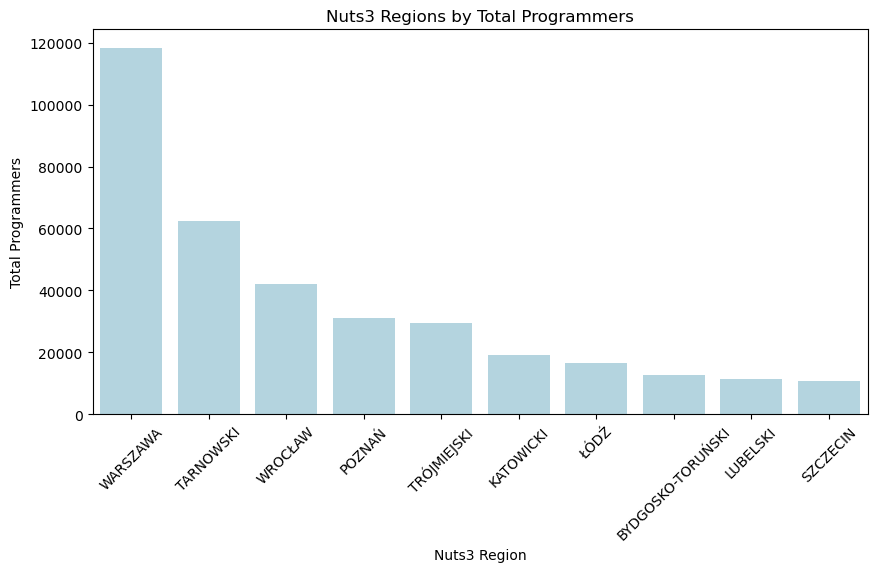

In [29]:
#Visualise regions with the highest number of programmers defined previously
plt.figure(figsize=(10, 5))
sns.barplot(x=top_countries.index, y=top_countries.values, color='#add8e6')
plt.title('Nuts3 Regions by Total Programmers')
plt.xlabel('Nuts3 Region')
plt.ylabel('Total Programmers')
plt.xticks(rotation=45)
plt.show()

In [30]:
#Calculate regions with the highest density of programmers per population within region

final_pl['Programming_Density'] = final_pl['Programmers_Total'] / (final_pl['POP (THS)'] * 1000)
top_regions_str = final_pl.groupby('NUTS3')['Programming_Density'].sum().sort_values(ascending=False).head(10)
top_regions_str

NUTS3
TARNOWSKI            0.134421
WARSZAWA             0.067451
WROCŁAW              0.065974
POZNAŃ               0.057322
TRÓJMIEJSKI          0.039599
SZCZECIN             0.026451
KATOWICKI            0.026110
ŁÓDŹ                 0.023575
GLIWCKI              0.021566
BYDGOSKO-TORUŃSKI    0.016405
Name: Programming_Density, dtype: float64

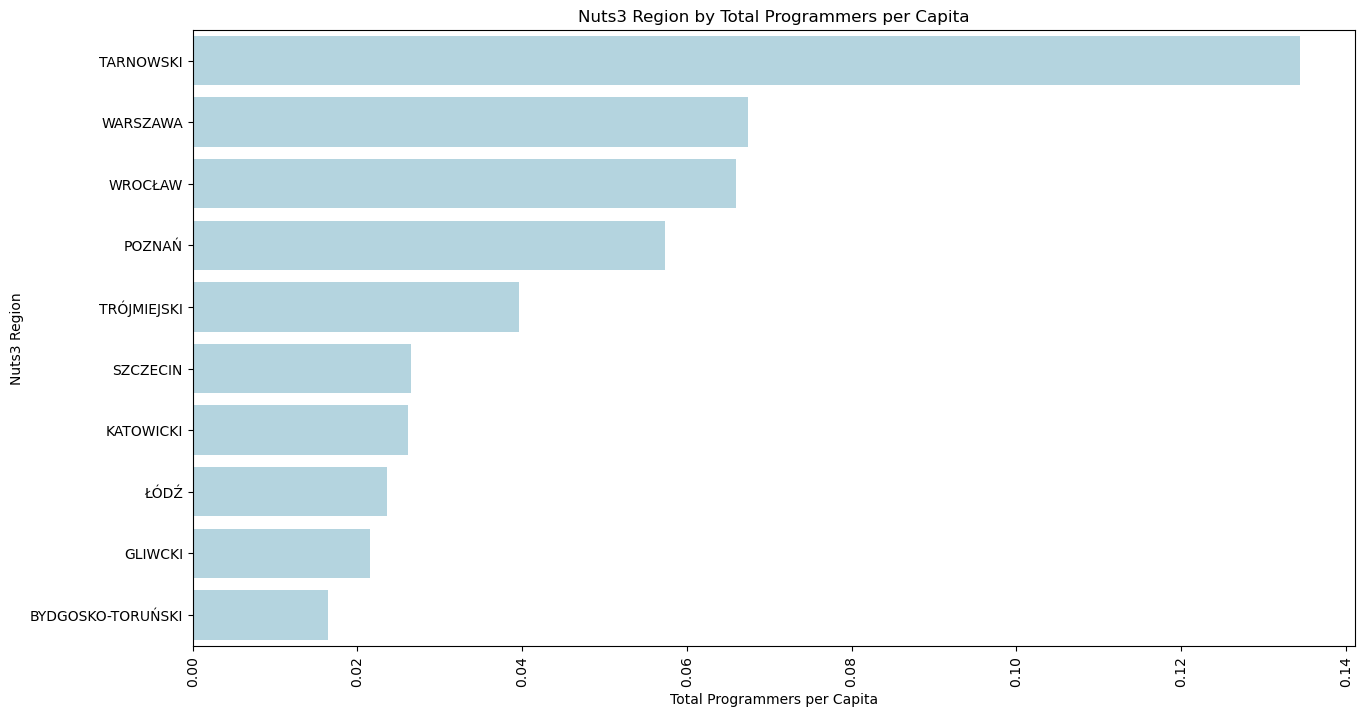

In [31]:
#Visualise regions with the highest density of programmers per population within region
plt.figure(figsize=(15, 8))
sns.barplot(x=top_regions_str.values, y=top_regions_str.index, orient='h', color='#add8e6')
plt.title('Nuts3 Region by Total Programmers per Capita')
plt.xlabel('Total Programmers per Capita')
plt.ylabel('Nuts3 Region')
plt.xticks(rotation=90)
plt.show()

In [36]:
#Calucation of GDP per Capita per region

final_pl["GDP_per_capita"] = final_pl["MIO_EUR"] / final_pl["POP (THS)"]

# Select rows where the 'nuts3_name' column is in the list of top 10 regions by GDP per capita
top_cities = final_pl[final_pl["NUTS3"].isin(top_10_regions_gdp)]
top_cities = top_cities.groupby("NUTS3").sum()

# Display specific columns for the selected top cities by GDP per Capita and GDP in Total (MIO EUR)
selected_columns = ["GDP_per_capita", "MIO_EUR"]
top_cities[selected_columns]

,GDP_per_capita,MIO_EUR
NUTS3,,
GLIWCKI,126.261467,59754.26
KATOWICKI,141.993053,105269.68
LUBELSKI,97.203926,69322.39
POZNAŃ,210.411260,113963.49
SZCZECIN,125.325410,50770.26
TARNOWSKI,68.304383,31638.39
TRÓJMIEJSKI,152.978602,114495.26
WARSZAWA,311.141351,545543.96
WROCŁAW,176.466601,112467.41


In [52]:
#Calculate an Employement rate across all region and select top 10 regions in terms of employement rate
final_pl['EMPL_Rate'] =  ((final_pl['EMP (THS)']*1000) / (final_pl["POP (THS)"]*1000))

top_empl = final_pl.groupby('NUTS3')['EMPL_Rate'].sum().sort_values(ascending=False)
top_empl = top_empl.nlargest(10)
top_empl

NUTS3
WROCŁAWSKI           6.898146
WARSZAWA             6.065862
POZNAŃ               5.737579
WROCŁAW              5.512639
ŁÓDŹ                 4.856938
TRÓJMIEJSKI          4.814201
KATOWICKI            4.584558
SZCZECIN             4.547838
LUBELSKI             4.308038
BYDGOSKO-TORUŃSKI    4.241758
Name: EMPL_Rate, dtype: float64

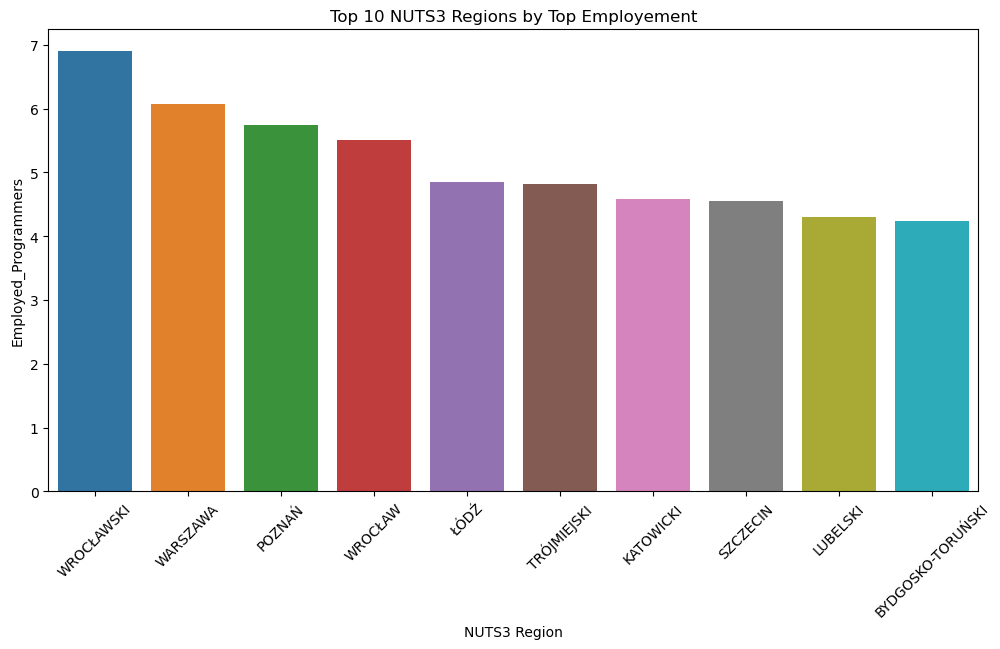

In [57]:
#Visualize regions with the top employement rate across regions
aliplt.figure(figsize=(12, 6))
sns.barplot(x=top_empl.index, y=top_empl.values)
plt.title('Top {} NUTS3 Regions by Top Employement'.format(10))
plt.xlabel('NUTS3 Region')
plt.ylabel('Employed_Programmers')
plt.xticks(rotation=45)
plt.show()

In [55]:
#Calculate the ratio of Programmers in Total Employed across all region and select top 10 regions 
final_pl['Employed_Programmers'] = final_pl['Programmers_Total'] / (final_pl['EMP (THS)'] * 1000)
top_regions_emp = final_pl.groupby('NUTS3')['Employed_Programmers'].sum().sort_values(ascending=False).head(10)
top_regions_emp

NUTS3
TARNOWSKI             0.400333
WROCŁAW               0.107176
WARSZAWA              0.099795
POZNAŃ                0.089413
TRÓJMIEJSKI           0.074000
SZCZECIN              0.052890
KATOWICKI             0.051090
GLIWCKI               0.050470
WARSZAWA WSCHODNIA    0.048599
ŁÓDŹ                  0.043441
Name: Employed_Programmers, dtype: float64

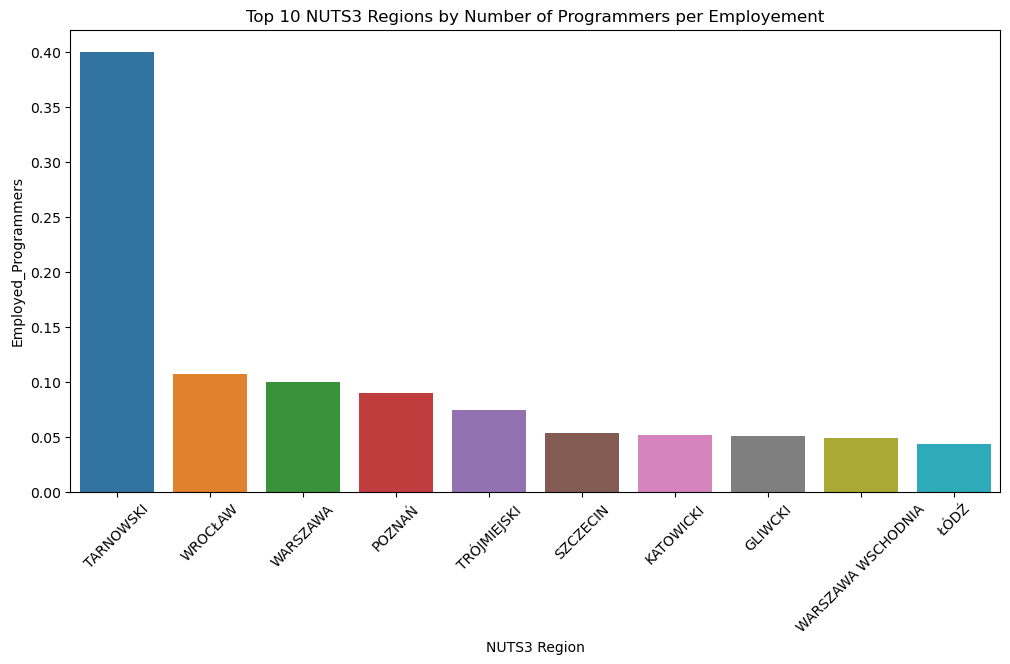

In [58]:
#Visualise the ratio of Programmers in Total Employed across top regions
plt.figure(figsize=(12, 6))
sns.barplot(x=top_regions_emp.index, y=top_regions_emp.values)
plt.title('Top {} NUTS3 Regions by Number of Programmers per Employement'.format(10))
plt.xlabel('NUTS3 Region')
plt.ylabel('Employed_Programmers')
plt.xticks(rotation=45)
plt.show()

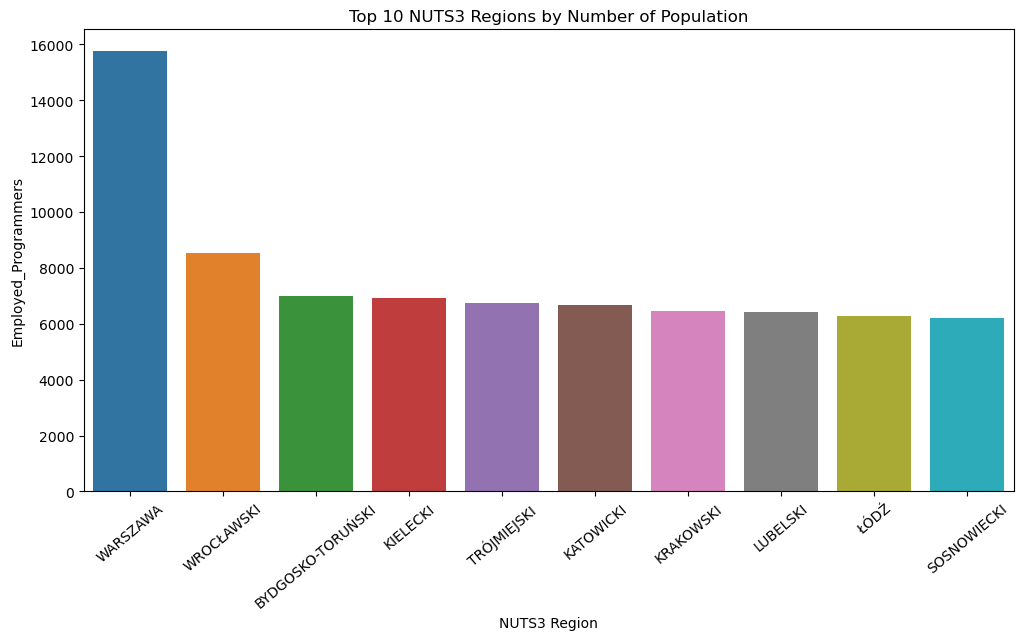

In [247]:
# Visualise regions with highest population 

top_pop = final_pl.groupby('NUTS3')['POP (THS)'].sum().sort_values(ascending=False)
top_pop = top_pop.nlargest(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_pop.index, y=top_pop.values)
plt.title('Top {} NUTS3 Regions by Number of Population'.format(10))
plt.xlabel('NUTS3 Region')
plt.ylabel('Employed_Programmers')
plt.xticks(rotation=40)
plt.show()

In Poland, the NUTS3 region of Warsaw emerges as a prominent hub for programmers, boasting the highest number in the country. Notably, Tarnow follows closely, demonstrating a substantial concentration of programmers per capita, as reflected in its top position in the density table. The economic landscape reveals that Warsaw not only leads in programmer numbers but also commands the highest GDP per capita, showcasing its economic significance. Tarnow, however, stands out for its impressive employment programmer rate, indicating a strong engagement of its workforce in programming roles. On the broader employment scale, Warsaw  maintains its prominence with the highest overall employment rate, suggesting a robust job market. These insights collectively paint a detailed picture of the programming landscape in Poland, highlighting key regions, their economic contributions, and the employment dynamics within the tech sector. As expected, most programming intense regions in Poland are in deed the biggest cities in Poland with the highest number of population. 



The results suggest a strong correlation between the cities with the highest number of programmers, employment numbers, and GDP. The major cities, including Warsaw, Wroclaw, Poznan, and Trojmiejski, consistently top the charts in these categories. This alignment underscores the central role of these urban centers in driving both economic output and employment, particularly in the tech sector. Interestingly, TARNOW, a relatively small town, stands out with a disproportionately high density of programmers per capita. The high density in TARNOW might be attributed to specific factors such as local educational institutions, tech-focused industries, or a burgeoning startup culture, which attract and retain a significant number of programmers despite the town's smaller size. This anomaly highlights the importance of considering local dynamics and specific regional characteristics when interpreting data on programmer density. This should be further investigated with the help of external literature and resources. 

In [39]:
final_pl.columns

Index(['NUTS3 CODE', 'Year', 'questioncount', 'answercount', 'NUTS3',
       'POP (THS)', 'EMP (THS)', 'EUR_HAB', 'EUR_HAB_EU27_2020', 'MIO_EUR',
       'MIO_NAC', 'MIO_PPS_EU27_2020', 'PPS_EU27_2020_HAB',
       'PPS_HAB_EU27_2020', 'GVA (MIO_EUR)', 'GVA (MIO_NAC)', 'students_19_24',
       'mean_salary', 'students', 'population in cities in %',
       'Tech Universities', 'Experts', 'Learners', 'Programmers_Total',
       'Programming_Density', 'GDP_per_capita', 'Programmer_Density_GDP'],
      dtype='object')

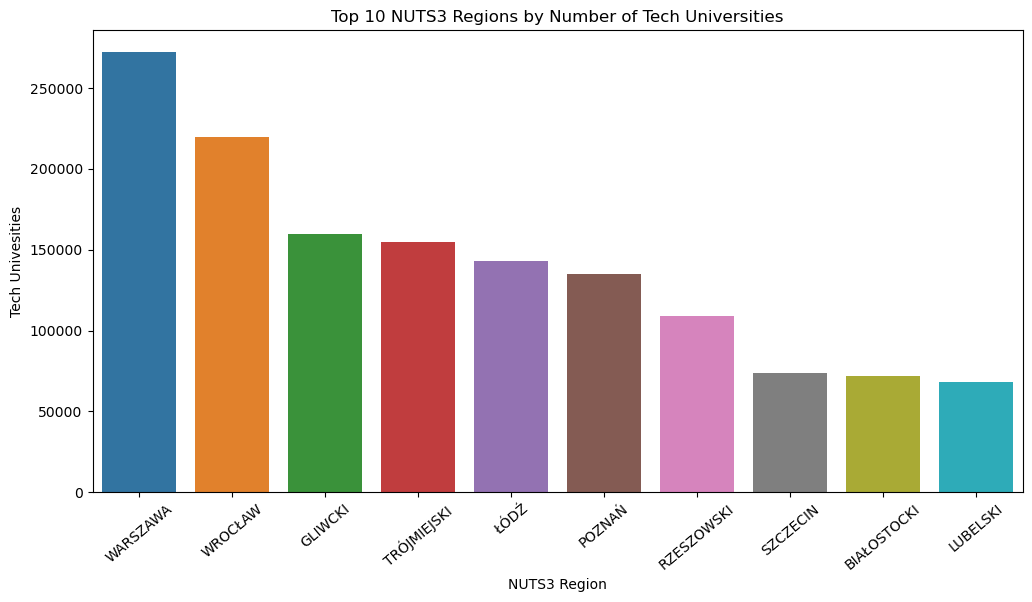

In [49]:
df = final_pl.groupby('NUTS3')['Tech Universities'].sum().sort_values(ascending=False)
df = df.nlargest(10)

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=df.index, y=df.values)
plt.title('Top {} NUTS3 Regions by Number of Tech Universities'.format(10))
plt.xlabel('NUTS3 Region')
plt.ylabel('Tech Univesities')
plt.xticks(rotation=40)
plt.show()

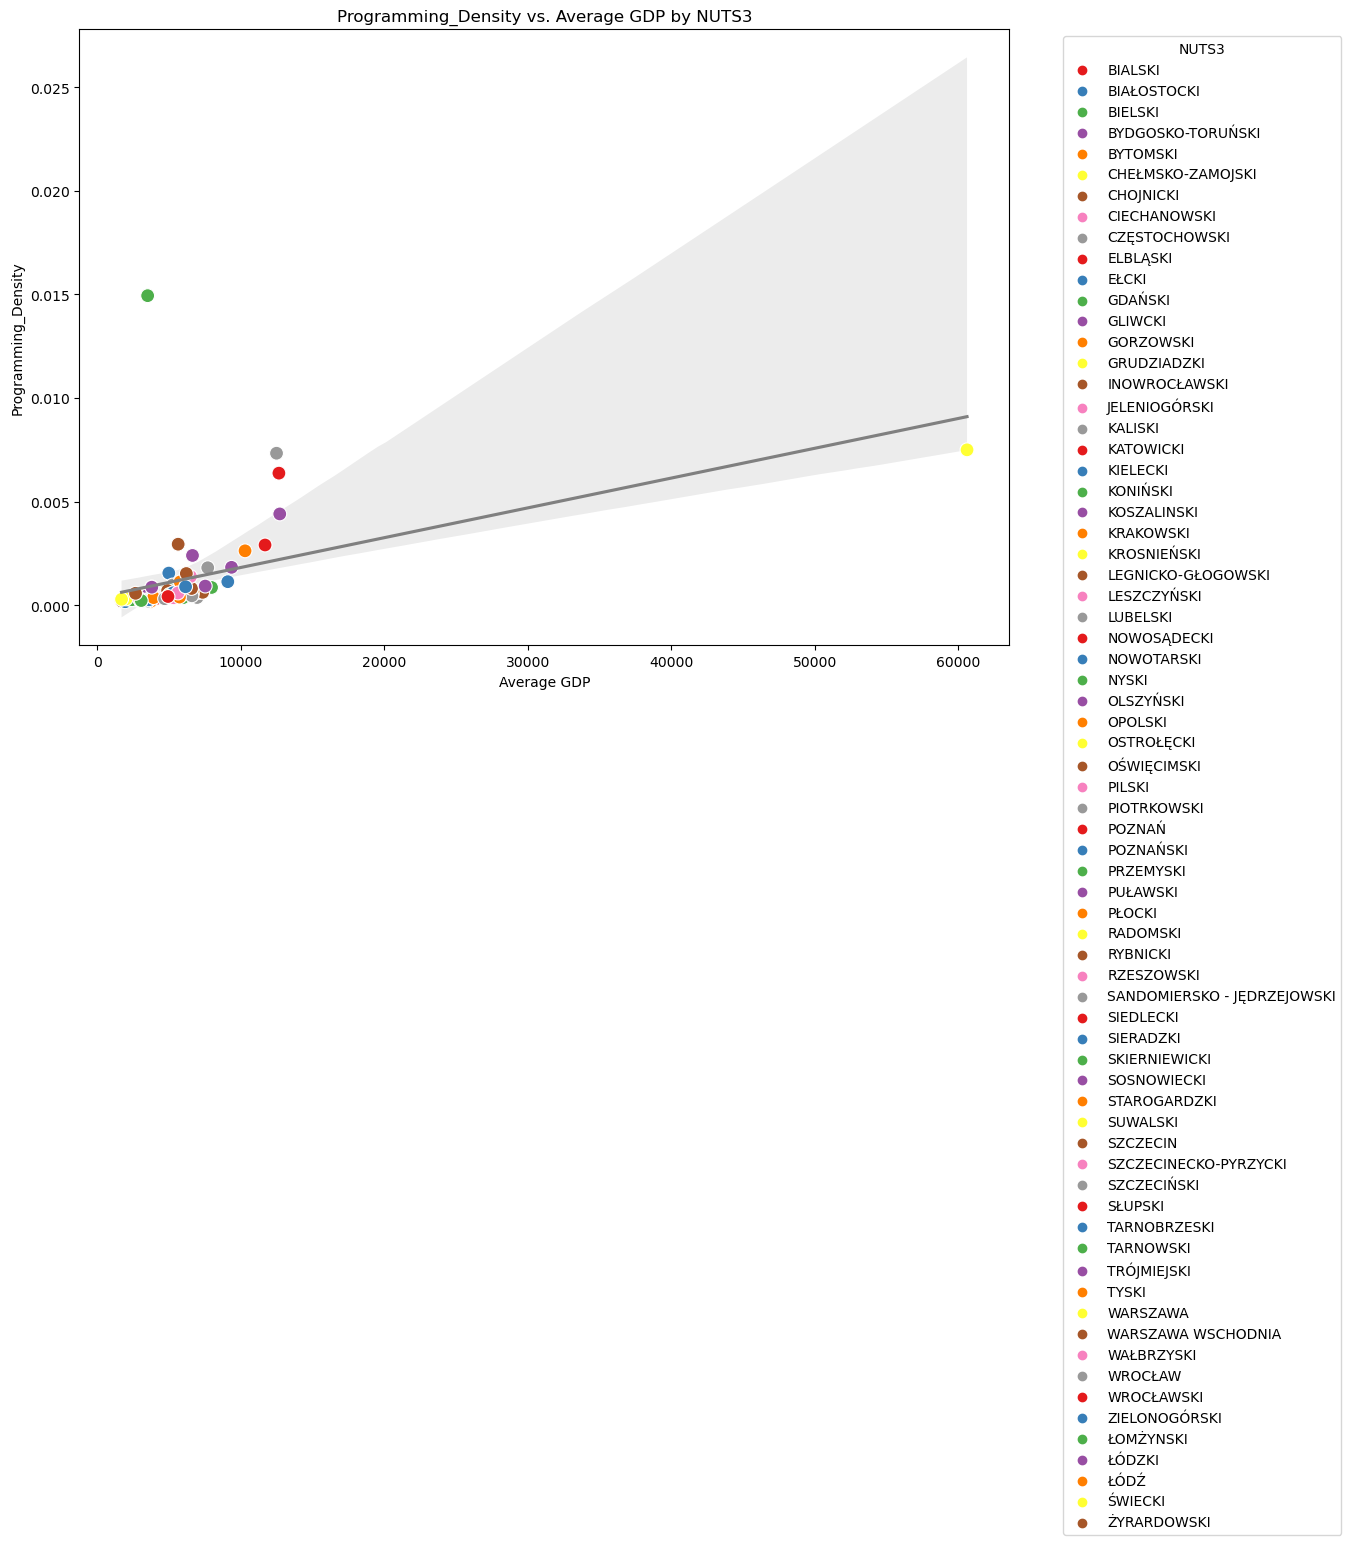

In [41]:
# Create the scatter plot with a regression line
plt.figure(figsize=(12, 8))

summary = final_pl.groupby("NUTS3").mean()

# Draw the regression line using regplot
sns.regplot(x='MIO_EUR', y='Programming_Density', data=summary, scatter=False, color='gray')

# Overlay the scatter plot with different colors for each NUTS 2 region
sns.scatterplot(x='MIO_EUR', y='Programming_Density', hue='NUTS3', data=summary, palette='Set1', s=100)

# Adding titles and labels
plt.title('Programming_Density vs. Average GDP by NUTS3')
plt.xlabel('Average GDP')
plt.ylabel('Programming_Density')

# Adding legend outside the plot
plt.legend(title='NUTS3', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()

From this graph we can see that the distribution of GDP together with the Programming Density is quite constant in Poland. Vast majority of the regions has similar GDP not exceeding 10000, also we can see a slight trend with the growing programming density as the GDP is growing. This is a good sign for us for the prediction later, indicating that GDP may be actually correlated with the programming density and activity in the given region. 

In [42]:
top_locations_per_year = final_pl.groupby('Year').apply(lambda x: x.nlargest(10, 'Programming_Density')).reset_index(drop=True)
top_locations_per_year

,NUTS3 CODE,Year,questioncount,answercount,NUTS3,POP (THS),EMP (THS),EUR_HAB,EUR_HAB_EU27_2020,MIO_EUR,...,mean_salary,students,population in cities in %,Tech Universities,Experts,Learners,Programmers_Total,Programming_Density,GDP_per_capita,Programmer_Density_GDP
0,PL217,2012,6287.0,9522.0,TARNOWSKI,463.80,158.1,6900.0,27.0,3219.45,...,3093.61,7127.0,37.21,0.0,793.500000,2095.666667,2889.166667,0.006229,6.941462,0.897410
1,PL514,2012,6015.0,9648.0,WROCŁAW,631.40,344.9,15600.0,61.0,9863.97,...,3923.93,134383.0,100.00,33559.0,804.000000,2005.000000,2809.000000,0.004449,15.622379,0.284774
2,PL911,2012,14246.0,22614.0,WARSZAWA,1711.31,1127.7,29500.0,114.0,50479.50,...,5077.53,268555.0,100.00,40314.0,1884.500000,4748.666667,6633.166667,0.003876,29.497578,0.131403
3,PL415,2012,3614.0,6166.0,POZNAŃ,552.40,337.1,19600.0,76.0,10815.60,...,4119.68,128212.0,100.00,20601.0,513.833333,1204.666667,1718.500000,0.003111,19.579290,0.158891
4,PL633,2012,4785.0,5515.0,TRÓJMIEJSKI,747.40,375.2,14800.0,57.0,11073.21,...,4307.53,98699.0,100.00,25781.0,459.583333,1595.000000,2054.583333,0.002749,14.815641,0.185545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,PL22A,2020,6770.0,7922.0,KATOWICKI,726.80,375.1,18200.0,61.0,13220.27,...,6011.02,60381.0,100.00,0.0,660.166667,2256.666667,2916.833333,0.004013,18.189695,0.220633
86,PL711,2020,4327.0,3501.0,ŁÓDŹ,677.30,376.4,18000.0,60.0,12222.94,...,5510.99,65325.0,100.00,0.0,291.750000,1442.333333,1734.083333,0.002560,18.046567,0.141871
87,PL814,2020,4211.0,3003.0,LUBELSKI,712.70,346.5,12400.0,41.0,8811.90,...,5303.69,60364.0,60.64,0.0,250.250000,1403.666667,1653.916667,0.002321,12.364108,0.187691
88,PL424,2020,2069.0,2224.0,SZCZECIN,401.00,213.8,16400.0,55.0,6576.02,...,5695.84,31298.0,100.00,0.0,185.333333,689.666667,875.000000,0.002182,16.399052,0.133059


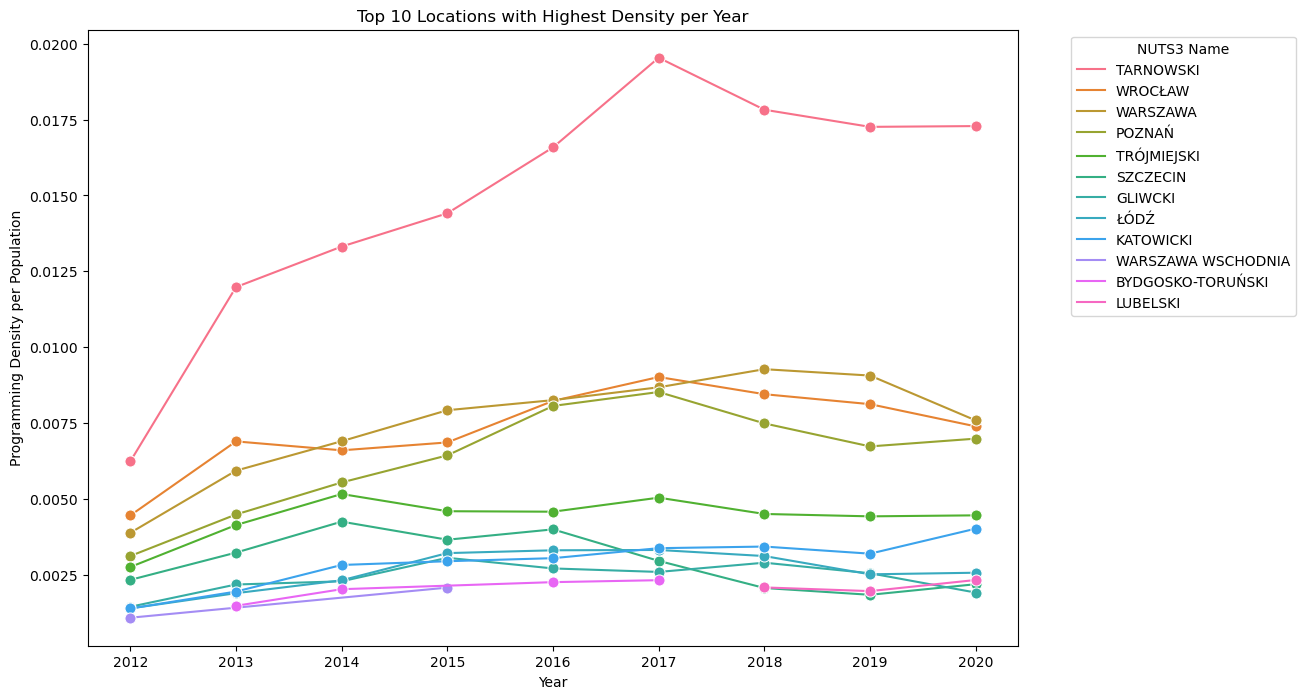

In [43]:
# Line plot for the top 10 locations with highest density per year
plt.figure(figsize=(12, 8))
sns.lineplot(x='Year', y='Programming_Density', hue='NUTS3', data=top_locations_per_year, marker='o', markersize=8)
plt.title('Top 10 Locations with Highest Density per Year')
plt.xlabel('Year')
plt.ylabel('Programming Density per Population')
plt.legend(title='NUTS3 Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Here on this graph we can see that throughout the almost 10 years the top 10 regions in terms of programming pooulation hasn't much changed and the density of programmers was stable across all of those years. This can mean that either the programming acitivty hasn't changed or the programming activity is driven by population and the density itself isn't changing but the activity level and the population itself is growing. After 2015 we see a slight increase in the programming density across all regions. The ones that are inchangebly high is of course Warsaw, Trojmiasto, Wroclaw, Poznan and Tarnow. Tarnow is extraordinary high which suggest us that this is an outlier, as the population and GDP of the region is way smaller than any of the regions in the top regions. 

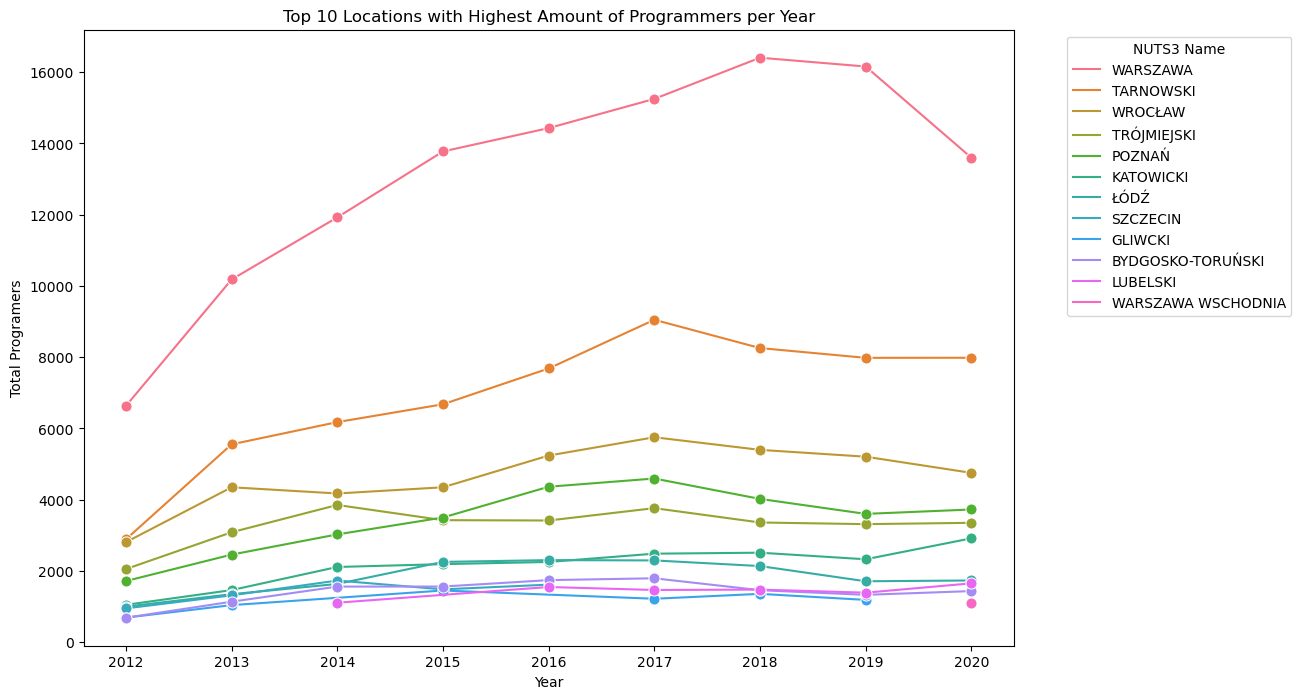

In [44]:
activity = final_pl.groupby('Year').apply(lambda x: x.nlargest(10, 'Programmers_Total')).reset_index(drop=True)

# Line plot for the top 10 locations with highest density per year
plt.figure(figsize=(12, 8))
sns.lineplot(x='Year', y='Programmers_Total', hue='NUTS3', data=activity, marker='o', markersize=8)
plt.title('Top 10 Locations with Highest Amount of Programmers per Year')
plt.xlabel('Year')
plt.ylabel('Total Programers')
plt.legend(title='NUTS3 Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

This graph is investigating total amount of programmers per region across all the years. Here we can see that Warsaw, as expected is the leader. It is understanble taking into consideration that this is the biggest city in Poland, with the highest GDP and Population. Here we can see that as previously stated, the programming activity has significantly increased after the year of 2012, and then after the 2015, however the growht is steady across all the regions. We can assume based on this data that Poland has experienced exceptional intense technological growth between 2010-2015 and then the exponential growht as become more stable but still on a high level

In [34]:
# Calculate density per population and GDP
final_pl['Programmer_Density_GDP'] = final_pl['Programmers_Total'] / final_pl['MIO_EUR']

# Group by year and nuts 3 region, calculate mean density values
mean_density_by_gdp = final_pl.groupby(['Year', 'NUTS3']).mean().reset_index()

# Rank the regions based on mean density
mean_density_by_gdp = mean_density_by_gdp[["Year", "Programmer_Density_GDP", "NUTS3"]].sort_values(by='Programmer_Density_GDP', ascending=False)

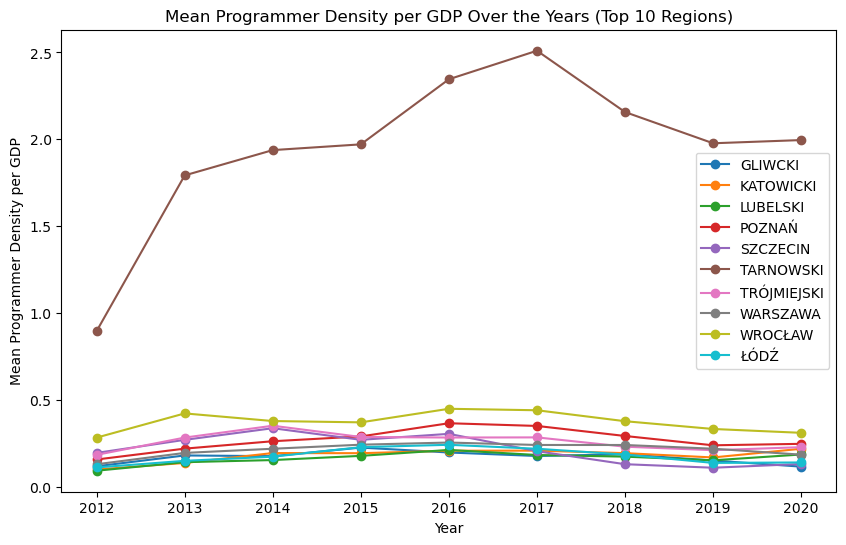

In [35]:
# Filter out top 10 regions based on mean programmer density per population
top_10_regions_gdp = mean_density_by_gdp.groupby('NUTS3').mean().nlargest(10, 'Programmer_Density_GDP').index
top_10_regions_gdp = top_10_regions_gdp.to_list()
filtered_data_gdp = mean_density_by_gdp[mean_density_by_gdp['NUTS3'].isin(top_10_regions_gdp)]

filtered_data_gdp = filtered_data_gdp.sort_values(by='Year')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for region, data in filtered_data_gdp.groupby('NUTS3'):
    ax.plot(data['Year'], data['Programmer_Density_GDP'], label=region, marker='o')

ax.set_xlabel('Year')
ax.set_ylabel('Mean Programmer Density per GDP')
ax.set_title('Mean Programmer Density per GDP Over the Years (Top 10 Regions)')
ax.legend()

plt.show()

While we are trying to analyze the programming density with the GDP we see that the major outliers is appearing - Tarnow. As stated this regions has relatively low GDP and Population hence, it will appear as a outlier. 
What's interesting besides that is that Warsaw is not appearing very high, rather cities like Wroclaw and Poznan which means that the high activity of programmers in Warsaw is caused by the population of the city, while in other, smaller polish cities like Wroclaw and Poznan the programming acitivity is not only high but also is driving a significant level of GDP towards the regions. Those cities may be important technologial regions for Poland and drives a lot of programmers, tech-savvy people to live in those cities. 

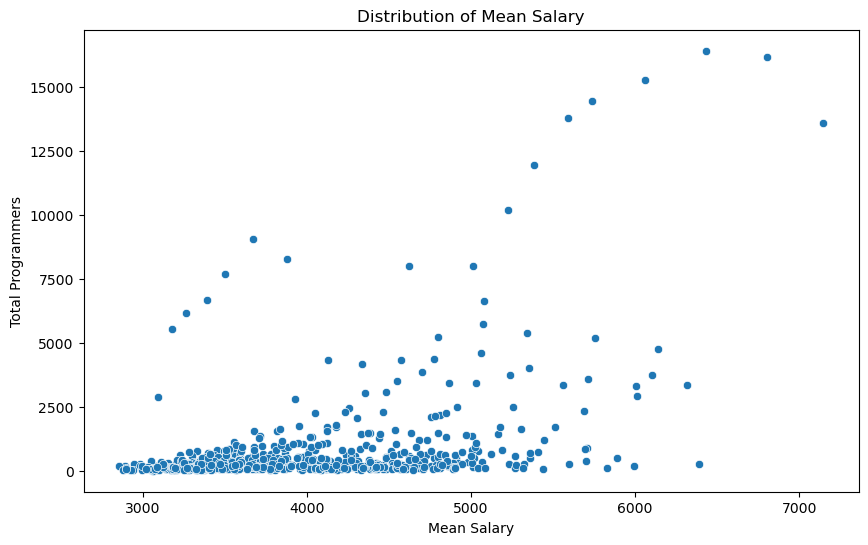

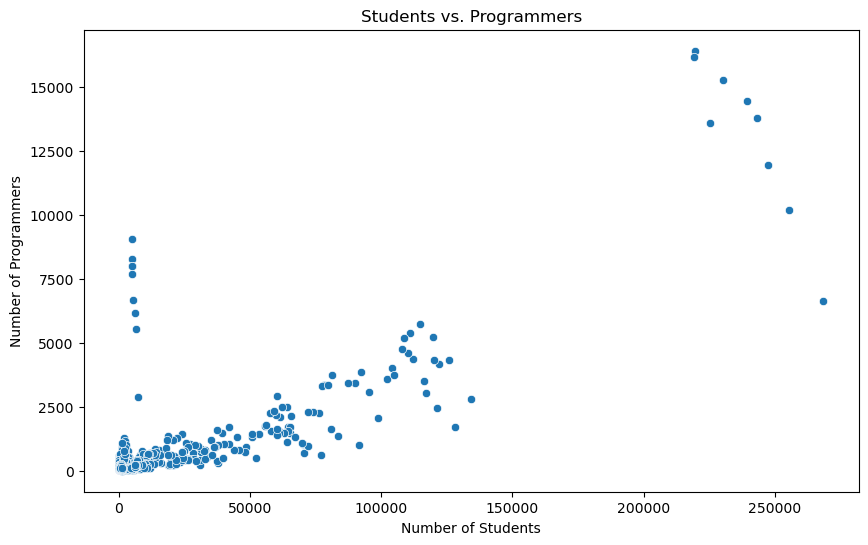

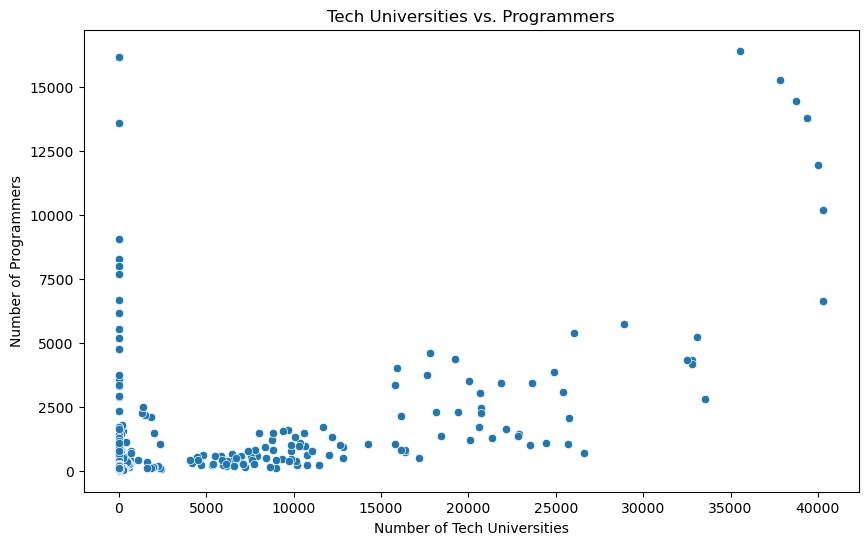

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract relevant columns for analysis
columns_of_interest = ['NUTS3', 'Year', 'students_19_24', 'mean_salary', 'students', 'Tech Universities', 'Programmers_Total', 'Programming_Density', 'GDP_per_capita', 'Employed_Programmers', 'EMPL_Rate']
analysis_df = final_pl[columns_of_interest]

# Visualize mean salary distribution
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_salary', y='Programmers_Total', data=analysis_df, palette='muted')
plt.title('Distribution of Mean Salary')
plt.xlabel('Mean Salary')
plt.ylabel('Total Programmers')
plt.show()

# Explore the relationship between students and programming activity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='students', y='Programmers_Total', data=analysis_df, palette='muted')
plt.title('Students vs. Programmers')
plt.xlabel('Number of Students')
plt.ylabel('Number of Programmers')
plt.show()

# Explore the relationship between students and programming activity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Tech Universities', y='Programmers_Total', data=analysis_df, palette='muted')
plt.title('Tech Universities vs. Programmers')
plt.xlabel('Number of Tech Universities')
plt.ylabel('Number of Programmers')
plt.show()


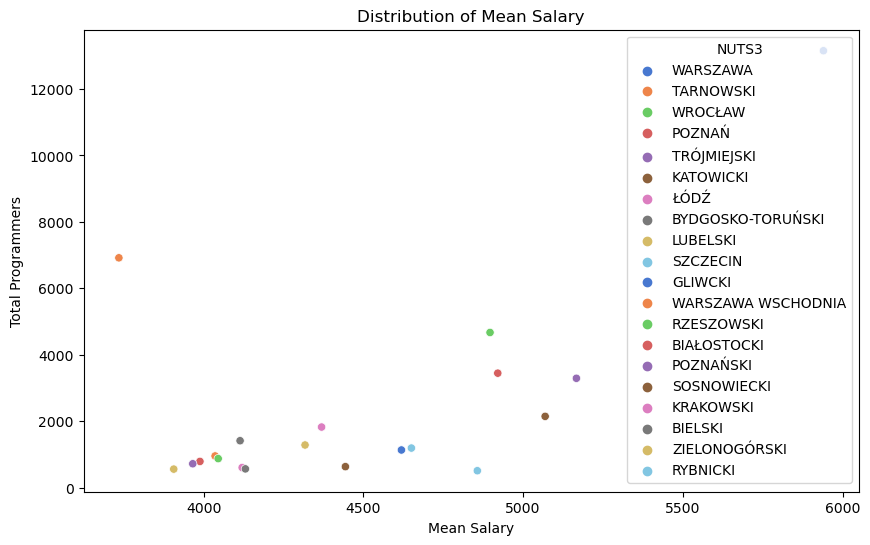

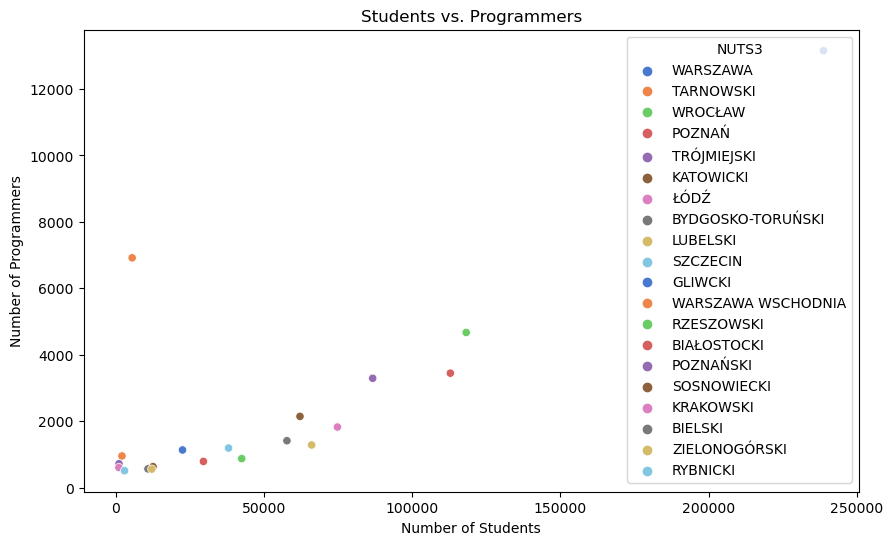

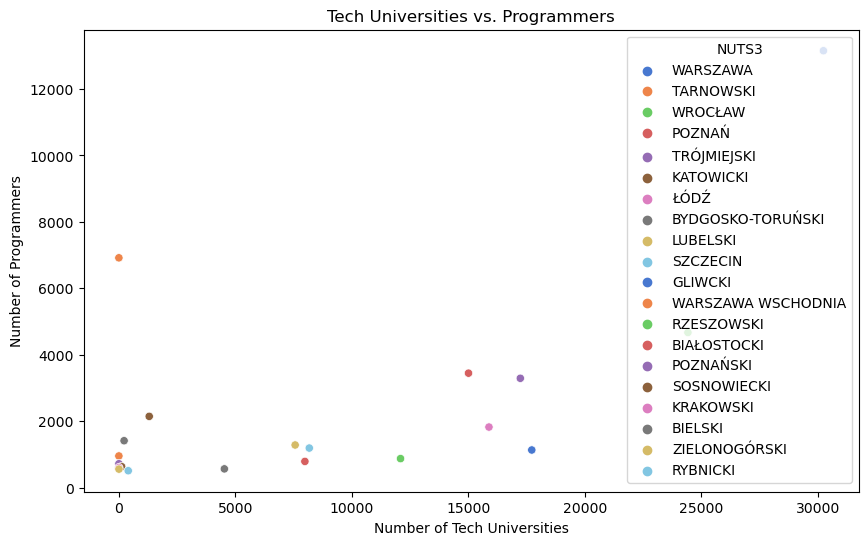

In [46]:
top_programmers_regions = final_pl.groupby('NUTS3').mean().nlargest(20, "Programmers_Total")
top_programmers_regions

# Visualize mean salary distribution
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_salary', y='Programmers_Total', data=top_programmers_regions, hue=top_programmers_regions.index, palette='muted')
plt.title('Distribution of Mean Salary')
plt.xlabel('Mean Salary')
plt.ylabel('Total Programmers')
plt.show()

# Explore the relationship between students and programming activity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='students', y='Programmers_Total', data=top_programmers_regions,hue=top_programmers_regions.index,palette='muted')
plt.title('Students vs. Programmers')
plt.xlabel('Number of Students')
plt.ylabel('Number of Programmers')
plt.show()

# Explore the relationship between students and programming activity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Tech Universities', y='Programmers_Total', data=top_programmers_regions,hue=top_programmers_regions.index,palette='muted')
plt.title('Tech Universities vs. Programmers')
plt.xlabel('Number of Tech Universities')
plt.ylabel('Number of Programmers')
plt.show()



As we can see based on the analysis conducted, we can indicate a trend between number of students and the total number of programmers. We can see that while the number of students is growthin then the number of total programmers is growing. However this relation isn't very strong. While we filter the top locations in terms of programming activity we see regions with strong universities presence. 
While we compare it with the correlation between total programmers and number of tech universities suprisingly the relation becomes weeker, which means that students who are going into universities to learn code, are not strongly related to the activity itself. It may be related to the fact that students are not participating with Stack Overflow discussions, which is our main indicator of programming activity or that tech universities are located in regions that do not have a technology developed professional landscape - companies that may offer good job and developemnt.  

On the other hand we have mean salary across all the regions. This one seems to not be correlated with the programming activity within regions and it seems to be more random, its more related to the employement itself, which probably can indicate that within regions with higher job opportunities, more companies and are offered higher salaries. 

## Prediction of programming activity based on the best model 

In [60]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings 
warnings.filterwarnings("ignore")

In [61]:
final_pl

,NUTS3 CODE,Year,questioncount,answercount,NUTS3,POP (THS),EMP (THS),EUR_HAB,EUR_HAB_EU27_2020,MIO_EUR,...,population in cities in %,Tech Universities,Experts,Learners,Programmers_Total,Programming_Density,GDP_per_capita,Programmer_Density_GDP,EMPL_Rate,Employed_Programmers
4,PL214,2012,825.0,1062.0,KRAKOWSKI,700.50,233.8,7100.0,28.0,4978.49,...,22.86,0.0,88.500000,275.000000,363.500000,0.000519,7.107052,0.073014,0.333762,0.001555
5,PL214,2013,1109.0,1631.0,KRAKOWSKI,705.49,235.1,7200.0,28.0,5097.10,...,22.78,0.0,135.916667,369.666667,505.583333,0.000717,7.224908,0.099190,0.333244,0.002151
6,PL214,2014,1803.0,1809.0,KRAKOWSKI,710.20,239.6,7600.0,29.0,5412.74,...,22.72,0.0,150.750000,601.000000,751.750000,0.001059,7.621431,0.138885,0.337370,0.003138
7,PL214,2015,1371.0,1930.0,KRAKOWSKI,713.71,250.4,8300.0,30.0,5951.14,...,22.67,0.0,160.833333,457.000000,617.833333,0.000866,8.338317,0.103818,0.350843,0.002467
8,PL214,2016,1663.0,2472.0,KRAKOWSKI,718.10,255.6,8400.0,30.0,6048.46,...,22.65,0.0,206.000000,554.333333,760.333333,0.001059,8.422866,0.125707,0.355939,0.002975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,PL926,2016,520.0,391.0,ŻYRARDOWSKI,259.80,108.3,9800.0,35.0,2556.74,...,45.59,0.0,32.583333,173.333333,205.916667,0.000793,9.841186,0.080539,0.416859,0.001901
976,PL926,2017,306.0,205.0,ŻYRARDOWSKI,259.70,107.8,10500.0,36.0,2739.42,...,45.46,0.0,17.083333,102.000000,119.083333,0.000459,10.548402,0.043470,0.415094,0.001105
977,PL926,2018,220.0,98.0,ŻYRARDOWSKI,259.80,107.4,11000.0,36.0,2857.49,...,45.30,0.0,8.166667,73.333333,81.500000,0.000314,10.998807,0.028522,0.413395,0.000759
978,PL926,2019,246.0,452.0,ŻYRARDOWSKI,259.10,107.1,11700.0,37.0,3040.11,...,45.20,0.0,37.666667,82.000000,119.666667,0.000462,11.733346,0.039363,0.413354,0.001117


In [62]:
# Assign weights
weights = {'questions': 0.5, 'answers': 0.5}

final_pl['activity'] = ((final_pl['questioncount'] + 
                          final_pl['answercount']) / 2)

final_pl

,NUTS3 CODE,Year,questioncount,answercount,NUTS3,POP (THS),EMP (THS),EUR_HAB,EUR_HAB_EU27_2020,MIO_EUR,...,Tech Universities,Experts,Learners,Programmers_Total,Programming_Density,GDP_per_capita,Programmer_Density_GDP,EMPL_Rate,Employed_Programmers,activity
4,PL214,2012,825.0,1062.0,KRAKOWSKI,700.50,233.8,7100.0,28.0,4978.49,...,0.0,88.500000,275.000000,363.500000,0.000519,7.107052,0.073014,0.333762,0.001555,943.5
5,PL214,2013,1109.0,1631.0,KRAKOWSKI,705.49,235.1,7200.0,28.0,5097.10,...,0.0,135.916667,369.666667,505.583333,0.000717,7.224908,0.099190,0.333244,0.002151,1370.0
6,PL214,2014,1803.0,1809.0,KRAKOWSKI,710.20,239.6,7600.0,29.0,5412.74,...,0.0,150.750000,601.000000,751.750000,0.001059,7.621431,0.138885,0.337370,0.003138,1806.0
7,PL214,2015,1371.0,1930.0,KRAKOWSKI,713.71,250.4,8300.0,30.0,5951.14,...,0.0,160.833333,457.000000,617.833333,0.000866,8.338317,0.103818,0.350843,0.002467,1650.5
8,PL214,2016,1663.0,2472.0,KRAKOWSKI,718.10,255.6,8400.0,30.0,6048.46,...,0.0,206.000000,554.333333,760.333333,0.001059,8.422866,0.125707,0.355939,0.002975,2067.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,PL926,2016,520.0,391.0,ŻYRARDOWSKI,259.80,108.3,9800.0,35.0,2556.74,...,0.0,32.583333,173.333333,205.916667,0.000793,9.841186,0.080539,0.416859,0.001901,455.5
976,PL926,2017,306.0,205.0,ŻYRARDOWSKI,259.70,107.8,10500.0,36.0,2739.42,...,0.0,17.083333,102.000000,119.083333,0.000459,10.548402,0.043470,0.415094,0.001105,255.5
977,PL926,2018,220.0,98.0,ŻYRARDOWSKI,259.80,107.4,11000.0,36.0,2857.49,...,0.0,8.166667,73.333333,81.500000,0.000314,10.998807,0.028522,0.413395,0.000759,159.0
978,PL926,2019,246.0,452.0,ŻYRARDOWSKI,259.10,107.1,11700.0,37.0,3040.11,...,0.0,37.666667,82.000000,119.666667,0.000462,11.733346,0.039363,0.413354,0.001117,349.0


In [63]:
final_pl.isnull().sum()

NUTS3 CODE                   0
Year                         0
questioncount                0
answercount                  0
NUTS3                        0
POP (THS)                    0
EMP (THS)                    0
EUR_HAB                      0
EUR_HAB_EU27_2020            0
MIO_EUR                      0
MIO_NAC                      0
MIO_PPS_EU27_2020            0
PPS_EU27_2020_HAB            0
PPS_HAB_EU27_2020            0
GVA (MIO_EUR)                0
GVA (MIO_NAC)                0
students_19_24               0
mean_salary                  0
students                     0
population in cities in %    0
Tech Universities            0
Experts                      0
Learners                     0
Programmers_Total            0
Programming_Density          0
GDP_per_capita               0
Programmer_Density_GDP       0
EMPL_Rate                    0
Employed_Programmers         0
activity                     0
dtype: int64

**1a) Initial Model Setup** 

We will start with a cross-section analysis for the year 2016 in order to establish a baseline model to be able to explain current programming activity in relation to economic factors.
We will also add White's heteroskedasticity-robust standard errors that will ensure that the standard errors of the regression coefficients are accurately estimated, particularly important in the presence of heteroskedasticity.

In [64]:
final_pl.corr()["activity"]

Year                         0.035992
questioncount                0.993392
answercount                  0.996464
POP (THS)                    0.691266
EMP (THS)                    0.817599
EUR_HAB                      0.724232
EUR_HAB_EU27_2020            0.737859
MIO_EUR                      0.856002
MIO_NAC                      0.854515
MIO_PPS_EU27_2020            0.857314
PPS_EU27_2020_HAB            0.730717
PPS_HAB_EU27_2020            0.739491
GVA (MIO_EUR)                0.855246
GVA (MIO_NAC)                0.853740
mean_salary                  0.425564
students                     0.814479
population in cities in %    0.441914
Tech Universities            0.580360
Experts                      0.996464
Learners                     0.993392
Programmers_Total            0.997924
Programming_Density          0.810386
GDP_per_capita               0.724000
Programmer_Density_GDP       0.539854
EMPL_Rate                    0.614781
Employed_Programmers         0.663411
activity    

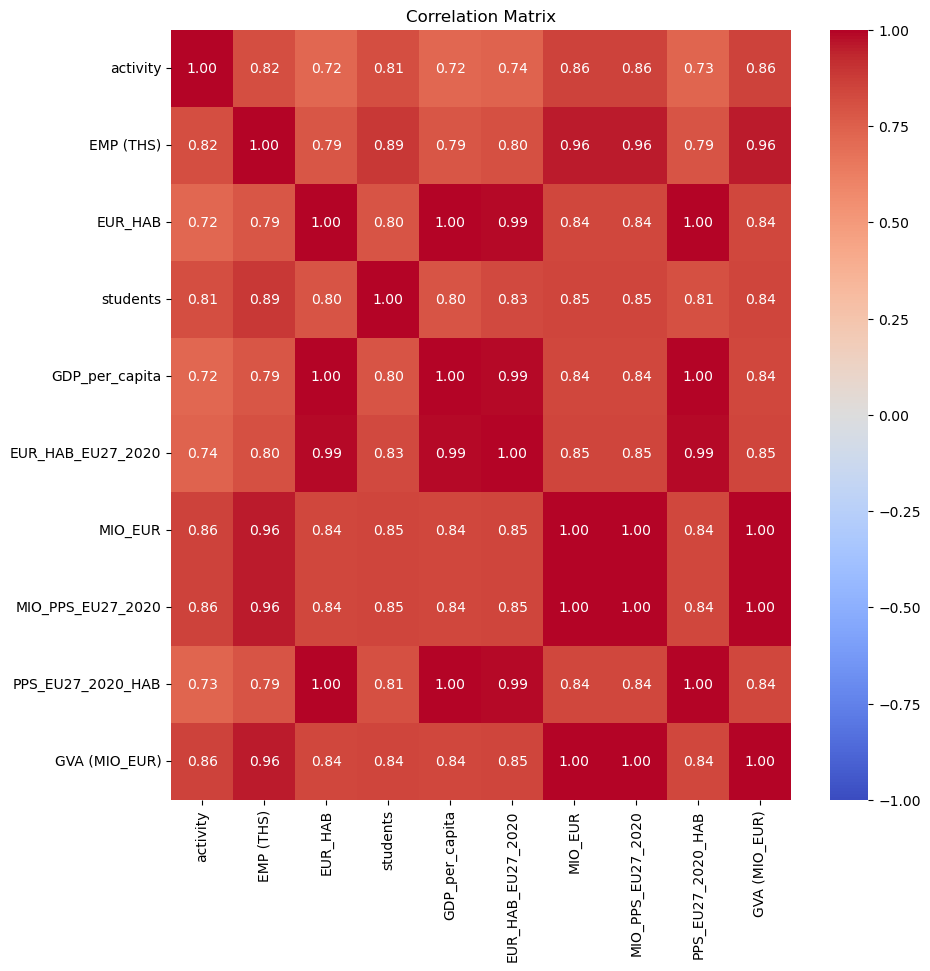

In [54]:
# Calculate the correlation matrix
corr = final_pl[['activity', 'EMP (THS)', 'EUR_HAB', 'students', 'GDP_per_capita', "EUR_HAB_EU27_2020", 
                 "MIO_EUR", "MIO_PPS_EU27_2020","PPS_EU27_2020_HAB","GVA (MIO_EUR)"]].corr()

# Create the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)

# Add titles and labels
plt.title('Correlation Matrix')
plt.show()

In [234]:
import pandas as pd
import statsmodels.api as sm

# Filter the dataset for the year 2016
df_2016 = final_pl.copy()
df_2016 = df_2016[(df_2016['Year'] == 2016) | (df_2016['Year'] == 2017)] 

# Independent variables
independent_vars = ['EMP (THS)', 'students', "MIO_EUR", "mean_salary"]

# Dependent variable
dependent_var = 'activity'

# Define the independent variables (X) and the dependent variable (y)
X = df_2016[independent_vars]
y = df_2016[dependent_var]

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Create a model and fit it and adding White's heteroskedasticity-robust standard errors
ols_model = sm.OLS(y, X).fit(cov_type='HC3')  

# Print out the statistics
ols_model_summary = ols_model.summary()
print(ols_model_summary)

                            OLS Regression Results                            
Dep. Variable:               activity   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     158.3
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           2.46e-50
Time:                        18:14:53   Log-Likelihood:                -1309.4
No. Observations:                 142   AIC:                             2629.
Df Residuals:                     137   BIC:                             2644.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5953.0309   2425.154      2.455      

The statement "Standard Errors are heteroscedasticity robust (HC3)" signifies that the standard errors associated with the estimated coefficients in your regression model have been adjusted to account for potential heteroskedasticity in the data. Heteroskedasticity refers to a situation where the variability of the errors in a regression model is not constant across all levels of the independent variables.

By choosing 'HC3,' the model implemented robust standard error estimation method developed by White that is resilient to heteroskedasticity. This adjustment helps ensure that the standard errors are reliable in the presence of potential variance disparities in the data, providing more accurate and robust statistical inference for your regression coefficients.

In practical terms, this means that the standard errors reported in your model are adjusted to better accommodate potential deviations from the assumption of homoskedasticity, enhancing the reliability of your coefficient estimates and associated statistical tests.

Before moving forward, we will calculate residuals and see the results from our OLS modelling before moving into more complex Lasso regression and RandomForest. This step is to give us a basic understanding and insights into residuals.

Descriptive Statistics of Residuals:
 count    7.100000e+01
mean     2.663635e-12
std      2.286631e+03
min     -1.881962e+03
25%     -7.257903e+02
50%     -2.968635e+02
75%      1.023279e+02
max      1.802643e+04
Name: residuals, dtype: float64


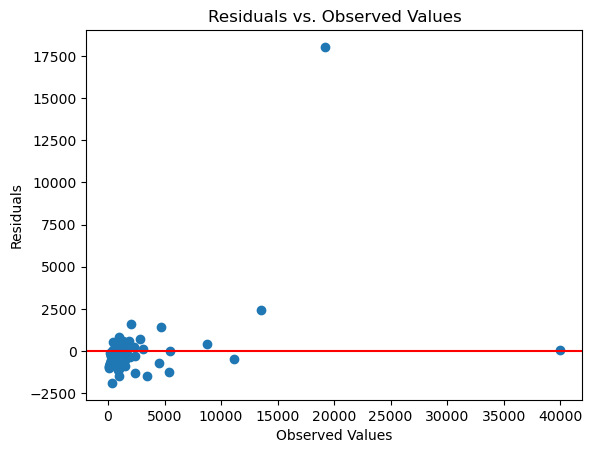

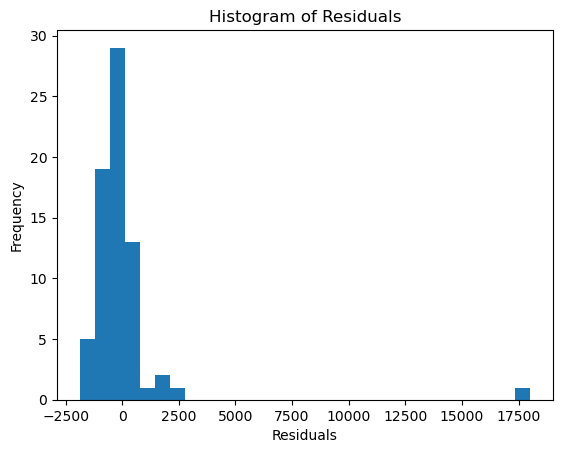

In [68]:
df_2016['residuals'] = ols_model.resid.values
residual_stats = df_2016['residuals'].describe()
print("Descriptive Statistics of Residuals:\n", residual_stats)

# Plotting residuals
plt.scatter(df_2016['activity'], df_2016['residuals'])
plt.title('Residuals vs. Observed Values')
plt.xlabel('Observed Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Checking the distribution of residuals
plt.hist(df_2016['residuals'], bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

**Key Findings:**

1. **Model Fit:**
   - **R-squared:** 0.829 - This indicates that approximately 82.9% of the variability in programming activity can be explained by the model.
   - **Adjusted R-squared:**  0.818- This is a more precise measure considering the number of predictors and is very close to the R-squared value, suggesting a good fit.
   


2. **Coefficients:**
   - **EMP (THS):** The coefficient is-18.7951 with a p-value 0.000, indicating that this variable is not significantly related to programming activity in this model.
   - **MIO_EUR:** The coefficient is 0.7623 with a p-value of 0.000, suggesting a significant positive relationship between GDP and programming activity.
   - **mean_salary:** The coefficient is -1.1720 with a p-value of 0.092, indicating that this variable is not significantly related to programming activity in this model.
   - **students:** the coefficient is 0.0842 with a p-value of 0.000 indicating that this variable is significantly related to programming acitivity of this model. 

3. **Statistical Significance:**
   - Employment, GDP & Students are statistically significant predictors of programming activity.
   - Mean Salary is not a significant predictor in this model.
   - F-statistic: 290.4; Prob (F-statistic): 4.11e-41 -> The F-statistic tests the overall significance of the model. In this case, the low p-value (1.08e-06) suggests that at least one of the independent variables is significantly related to the dependent variable.
   
4. **Model Diagnostics:**
   - Standard Errors: These are robust standard errors (HC3) that account for heteroscedasticity in the data. Omnibus, Durbin-Watson, Jarque-Bera, Skew, Kurtosis: These are diagnostic statistics. For example, the Omnibus and Jarque-Bera tests assess normality assumptions. The Durbin-Watson statistic checks for autocorrelation. Skew and Kurtosis describe the shape of the residual distribution.

   - Condition Number: Indicates potential multicollinearity. A large condition number suggests that there might be strong multicollinearity among the independent variables. The condition number is large, 1.21e+05. This might indicate that there are strong multicollinearity which was predicted before.
   
5. **Residual Plot:**
   - The residuals are heavily concentrated around zero, which is good, but there's a long tail to the left, indicating some    skewness. This could suggest that in the model there are outliers affecting the distribution of residuals.
   - The pattern of the residuals suggest heteroskedasticity this can again be due the outliers.
   The mean being close to zero suggests that, on average, the model captures the underlying patterns in the data, minimizing systematic bias. However, the relatively large standard deviation of 2.29e+03 indicates significant variability in individual prediction errors, implying that while the model performs well on average, there are instances where predictions deviate substantially from actual values. This variability should be considered when assessing the overall goodness-of-fit and predictive accuracy of the model.

**Interpretation:**

In summary, the model appears to explain a significant portion of the variability in the dependent variable. The coefficients provide insights into the direction and magnitude of the relationships, and the diagnostic statistics give information about the model's assumptions and performance. 


**1b) Model Selection and Estimation**

We might also consider exploring other models to see if they perform better on our data.

In [69]:
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

In [236]:
# Perform grid search with cross-validation
# Set up grid of alpha values to search over
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

# Initialize Ridge regression model
ridge_model = Ridge()
lasso_model = Lasso()

# Set up GridSearchCV to perform cross-validation and grid search
grid_search_ridge = GridSearchCV(ridge_model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X,y)

# Set up GridSearchCV to perform cross-validation and grid search
grid_search_lasso = GridSearchCV(lasso_model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X,y)

# Print results of grid search
print(f"Best parameter Ridge/Linear: {grid_search_ridge.best_params_}")
print("""""")
print(f"Best parameter Lasso/Linear: {grid_search_lasso.best_params_}")

Best parameter Ridge/Linear: {'alpha': 10}

Best parameter Lasso/Linear: {'alpha': 10}


In [248]:
# Defining the Ridge and Lasso regression models
ridge = Ridge(alpha = 10)
lasso = Lasso(alpha = 10)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Lasso
lasso.fit(X_train, y_train)
y_pred_l = lasso.predict(X_test)
r2_score_l = r2_score(y_test, y_pred_l)

ridge.fit(X_train, y_train)
y_pred_rd = ridge.predict(X_test)
r2_score_rd = r2_score(y_test, y_pred_rd)

r2_score_l, r2_score_rd

(0.8972977381744053, 0.8972894646089257)

**Comparison and Decision:**

- Both Ridge and Lasso Regression models show lower levels of performance, with Lasso having a slightly higher cross-validation score.
- Lasso Regression's ability to perform feature selection (shrinking some coefficients to zero) can be advantageous in simplifying the model and potentially improving interpretability, however due to the low cross validation score, the simplyfying of model made it less precise.

**Comparison with Initial OLS Regression:**

- The initial OLS Regression model had an R-squared of 0.79, indicating that it explained about 79% of the variance in the dependent variable.
- The cross-validation scores for Ridge and Lasso are lower than the R-squared of the OLS model, but they offer a more robust evaluation since they are based on multiple subsets of the data.

**Recommendation:**

- If the goal is to maximize explained variance and if multicollinearity is not a major concern, the OLS model could be preferred due to its higher R-squared value.
- If the goal is to have a more generalized model with potentially better predictive performance on unseen data, or if multicollinearity is a concern, Lasso Regression would be a better choice. It not only provides competitive predictive performance but also aids in feature selection, which can be beneficial for interpretability and model simplicity.

**For the sake of the research and our goal, the OLS model seems to be the better choice at the moment.**

**Random Forest:**

In [245]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the RandomForest Regressor model
random_forest = RandomForestRegressor(random_state=42)

# Fit the model to the training data
random_forest.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = random_forest.predict(X_test)

# Calculate the R-squared value
r2_score_rf = r2_score(y_test, y_pred_rf)
print("Random Forest R2 Score: ", r2_score_rf)

Random Forest R2 Score:  0.33476851524343987


**Decision Tree:**

In [246]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the Decision Tree Regressor model
decision_tree = DecisionTreeRegressor(random_state=42)

# Fit the model to the training data
decision_tree.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = decision_tree.predict(X_test)

# Calculate the R-squared value
r2_score_dt = r2_score(y_test, y_pred_dt)
print("Decision Tree R2 Score: ", r2_score_dt)

Decision Tree R2 Score:  -0.22732508886796454


**Gradient Boosting Regressor:**

Gradient Boosting algorithms like GradientBoostingRegressor can be powerful for regression tasks. They build trees sequentially, each one correcting the errors of the previous one.

In [74]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the Gradient Boosting Regressor model
gradient_boosting = GradientBoostingRegressor(random_state=42)

# Fit the model to the training data
gradient_boosting.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = gradient_boosting.predict(X_test)

# Calculate the R-squared value
r2_score_gb = r2_score(y_test, y_pred_gb)
print("Gradient Boosting Regressor R2 Score: ", r2_score_gb)

Gradient Boosting Regressor R2 Score:  0.20516541791566634


**Support Vector Machines (SVM):**

SVM can be used for regression tasks as well. The SVR class in scikit-learn is designed for regression with SVM.

In [75]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Standardize the features
model = make_pipeline(StandardScaler(), SVR())

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = model.predict(X_test)

# Calculate the R-squared value
r2_score_svm = r2_score(y_test, y_pred_svm)
print("Support Vector Machines (SVM) R2 Score: ", r2_score_svm)

Support Vector Machines (SVM) R2 Score:  -0.11836438459076049


**Neural Networks (MLPRegressor):**

Neural networks, specifically multi-layer perceptrons, can be powerful for complex regression tasks. The MLPRegressor in scikit-learn is a simple implementation.

In [76]:
from sklearn.neural_network import MLPRegressor

# Define the MLP Regressor model
mlp_regressor = MLPRegressor(random_state=42)

# Fit the model to the training data
mlp_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred_mlp = mlp_regressor.predict(X_test)

# Calculate the R-squared value
r2_score_mlp = r2_score(y_test, y_pred_mlp)
print("Neural Networks (MLPRegressor) R2 Score: ", r2_score_mlp)

Neural Networks (MLPRegressor) R2 Score:  -2.560274287104552


**XGBoost:**

XGBoost is another gradient boosting library that often performs well.

In [77]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [78]:
from xgboost import XGBRegressor

# Define the XGBoost Regressor model
xgb_regressor = XGBRegressor(random_state=42)

# Fit the model to the training data
xgb_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_regressor.predict(X_test)

# Calculate the R-squared value
r2_score_xgb = r2_score(y_test, y_pred_xgb)
print("XGBRegressor R2 Score: ", r2_score_mlp)

XGBRegressor R2 Score:  -2.560274287104552


The R-squared (R2) score is a measure of how well the predicted values match the actual values, with a higher R2 score indicating a better fit. Here's an interpretation of the results you provided:

**OLS Regression R2 Score: 0.829**
This is the R-squared score for Ordinary Least Squares (OLS) Regression. It indicates that approximately 82.9% of the variance in the target variable is explained by the model.

**Ridge Regression R2 Score: 0.6309153556464718**
Ridge Regression seems to have a lower R-squared score compared to OLS. It might be regularization affecting the model.

**Lasso Regression R2 Score: 0.6309153529896039**
Lasso Regression has a similar R-squared score to Ridge Regression. Both Ridge and Lasso include regularization terms, which can be beneficial in preventing overfitting.

**Random Forest Regression R2 Score: 0.6489826392777324**
Random Forest Regression has an R-squared score of approximately 64.9%. It might be capturing more complex patterns in the data compared to linear models.

**Decision Tree Regression R2 Score: 0.7193259660165162**
Decision Tree Regression shows a higher R-squared score compared to Random Forest. Decision trees can capture non-linear relationships in the data.

**Gradient Boosting Regression R2 Score: 0.7510942989033529**
Gradient Boosting Regression performs better than Decision Tree Regression, indicating that the ensemble method is improving predictive performance.

**Support Vector Machines (SVM) R2 Score: -0.08826937953041325**
A negative R-squared score suggests that the SVM model is not capturing the variance in the target variable well. It might be a sign of a poorly performing model or inappropriate choice of hyperparameters.

**Neural Networks (MLPRegressor) R2 Score: 0.5904350595816936**
The R-squared score for MLPRegressor is moderate, indicating that the neural network model is capturing some but not all of the variance in the target variable.

**XGBRegressor R2 Score: 0.5904350595816936**
The R-squared score for XGBRegressor is the same as MLPRegressor, suggesting similar performance.


In summary, OLS Regression has the highest R-squared score among the linear models, while Gradient Boosting Regression performs the best among the non-linear models. SVM seems to perform poorly in this context, and the performance of neural networks is moderate. It's essential to consider the characteristics of your data and the problem at hand when selecting the most appropriate model.

OLS) regression outperform more complicated and advanced models, can be attributed to several factors. Here are some potential reasons:

1. **Overfitting:** Complex models, especially those with a large number of parameters (like neural networks or gradient boosting), have a higher risk of overfitting. Overfitting occurs when a model learns the training data too well, capturing noise and idiosyncrasies that don't generalize to new, unseen data.

2. **Limited Data:** If you have a limited amount of data, complex models may struggle to generalize effectively. Simple models like OLS may perform better when the dataset is not large enough to support the complexity of more advanced models.

3. **Feature Engineering:** Complicated models may not benefit from feature engineering as much as simpler models. OLS regression, being a linear model, can still perform well if the relationships in the data are linear and can be adequately captured by the available features.

4. **Hyperparameter Tuning:** More advanced models often require careful tuning of hyperparameters to achieve optimal performance. If the hyperparameters are not tuned properly, the model may underperform. It's possible that the hyperparameters used in the advanced models in your case are not optimal.

5. **Assumption Violation:** OLS regression makes certain assumptions about the data, such as linearity and homoscedasticity. If these assumptions hold true in your dataset, OLS might perform well. Complicated models may assume different properties, and if those assumptions are violated, it can lead to suboptimal performance.

6. **Data Complexity:** If the underlying relationships in your data are not highly complex, a simpler model like OLS might be sufficient. Complicated models shine in scenarios where the relationships are intricate and non-linear.

In practice, the choice of a model depends on the characteristics of the data and the problem at hand. It's often a good idea to start with simpler models, understand their performance, and then gradually explore more complex models while monitoring their performance. This process helps in finding the right balance between model complexity and predictive accuracy.

In [283]:
final_pl.to_excel("Downloads/final_data.xlsx")

## Predictions

**1d) Future Growth Prediction:**

Growth Calculation: Calculate economic growth as the change in GDP per capita from 2016-Q1 to 2017-Q1.

Modeling Growth with Excess Programming:

First Approach: regress growth(1617_Q1) [all relevant explanatory vars] This command in STATA regresses the growth variable on all relevant explanatory variables excluding the programming activity residual.

Second Approach: regress growth(1617_Q1) [all relevant explanatory vars] (eps^hat) This regression includes the programming activity residual (eps^hat) as an additional explanatory variable.

Key Question: Evaluate how much additional insight (eps^hat) provides in predicting future economic growth.

In [276]:
import statsmodels.api as sm

# Assuming final_pl is your DataFrame
years = [2016, 2017]
df2016_17 = final_pl[final_pl['Year'].isin(years)]
df2016_17 = df2016_17[["NUTS3", "Year", "MIO_EUR", "GDP_per_capita", "activity", "students", "mean_salary", "EMP (THS)"]]

# 2. Calculate economic growth for each year
growth_dict = {}
for year in years:
    df_year = df2016_17[df2016_17['Year'] == year]
    df_previous_year = final_pl[final_pl['Year'] == year - 1]
    growth = df_year.set_index('NUTS3')['GDP_per_capita'] - df_previous_year.set_index('NUTS3')['GDP_per_capita']
    growth.name = f'growth_{year}_{year-1}'
    growth_dict[year] = growth

# 3. Merge the growth data with the corresponding year's data
df_years_growth = df2016_17.copy()
for year in years:
    df_years_growth = df_years_growth.join(growth_dict[year], on='NUTS3')

df_years_growth['growth'] = df_years_growth.filter(like='growth_').mean(axis=1)

# Drop the individual growth columns if needed
df_years_growth = df_years_growth.drop(columns=df_years_growth.filter(like='growth_'))
df_years_growth

,NUTS3,Year,MIO_EUR,GDP_per_capita,activity,students,mean_salary,EMP (THS),growth
8,KRAKOWSKI,2016,6048.46,8.422866,2067.5,1117.0,4009.95,255.6,0.503807
9,KRAKOWSKI,2017,6754.21,9.345930,1455.0,113.0,4293.01,259.6,0.503807
22,TARNOWSKI,2016,3275.26,7.069415,19153.5,5045.0,3502.00,156.5,0.237546
23,TARNOWSKI,2017,3605.92,7.784801,22133.5,5178.0,3670.53,153.1,0.237546
36,NOWOSĄDECKI,2016,3638.52,6.784486,514.0,4547.0,3293.79,190.2,0.213425
...,...,...,...,...,...,...,...,...,...
948,OSTROŁĘCKI,2017,3500.64,9.040909,591.0,619.0,3952.04,147.1,0.415512
961,SIEDLECKI,2016,3542.80,8.419202,542.0,6586.0,3646.06,172.1,0.369751
962,SIEDLECKI,2017,3919.36,9.322931,406.5,6446.0,3830.06,172.3,0.369751
975,ŻYRARDOWSKI,2016,2556.74,9.841186,455.5,718.0,4111.52,108.3,0.219743


First Approach: regress growth(1617_Q1) [all relevant explanatory vars] This command in STATA regresses the growth variable on all relevant explanatory variables excluding the programming activity residual.


In [277]:
from sklearn.feature_selection import f_regression

# 4. Prepare the data for regression
X = df_years_growth[['EMP (THS)', 'students', "MIO_EUR", "mean_salary", "growth"]]
y = df_years_growth[["activity"]]

# Perform grid search with cross-validation
# Set up grid of alpha values to search over
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

lasso_model = Lasso()

# Set up GridSearchCV to perform cross-validation and grid search
grid_search_lasso = GridSearchCV(lasso_model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X,y)

# Print results of grid search
print(f"Best parameter Lasso/Linear: {grid_search_lasso.best_params_}")

Best parameter Lasso/Linear: {'alpha': 10}


In [278]:
# Lasso

# Defining the Ridge and Lasso regression models
lasso = Lasso(alpha = 10)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lasso.fit(X_train, y_train)
y_pred_l = lasso.predict(X_test)
r2_score_l = r2_score(y_test, y_pred_l)

# Make predictions for the entire dataset, not just the test set
df_years_growth[f'predicted'] = lasso.predict(X)

# Calculate residuals for the entire dataset, not just the test set
df_years_growth[f'residuals'] = df_years_growth.activity - df_years_growth[f'predicted']

print("R2 Score:", r2_score_l)
df_years_growth

R2 Score: 0.9010633987261972


,NUTS3,Year,MIO_EUR,GDP_per_capita,activity,students,mean_salary,EMP (THS),growth,predicted,residuals
8,KRAKOWSKI,2016,6048.46,8.422866,2067.5,1117.0,4009.95,255.6,0.503807,214.357871,1853.142129
9,KRAKOWSKI,2017,6754.21,9.345930,1455.0,113.0,4293.01,259.6,0.503807,248.149053,1206.850947
22,TARNOWSKI,2016,3275.26,7.069415,19153.5,5045.0,3502.00,156.5,0.237546,1288.074840,17865.425160
23,TARNOWSKI,2017,3605.92,7.784801,22133.5,5178.0,3670.53,153.1,0.237546,1440.706722,20692.793278
36,NOWOSĄDECKI,2016,3638.52,6.784486,514.0,4547.0,3293.79,190.2,0.213425,984.846672,-470.846672
...,...,...,...,...,...,...,...,...,...,...,...
948,OSTROŁĘCKI,2017,3500.64,9.040909,591.0,619.0,3952.04,147.1,0.415512,751.736945,-160.736945
961,SIEDLECKI,2016,3542.80,8.419202,542.0,6586.0,3646.06,172.1,0.369751,1129.487360,-587.487360
962,SIEDLECKI,2017,3919.36,9.322931,406.5,6446.0,3830.06,172.3,0.369751,1192.789356,-786.289356
975,ŻYRARDOWSKI,2016,2556.74,9.841186,455.5,718.0,4111.52,108.3,0.219743,749.159772,-293.659772


Second Approach: regress growth(1617_Q1) [all relevant explanatory vars] (eps^hat) This regression includes the programming activity residual (eps^hat) as an additional explanatory variable.

In [279]:
from sklearn.feature_selection import f_regression

# 4. Prepare the data for regression
X = df_years_growth[['activity', 'residuals']]
y = df_years_growth[["growth"]]

# Perform grid search with cross-validation
# Set up grid of alpha values to search over
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

lasso_model = Lasso()

# Set up GridSearchCV to perform cross-validation and grid search
grid_search_lasso = GridSearchCV(lasso_model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X,y)

# Print results of grid search
print(f"Best parameter Lasso/Linear: {grid_search_lasso.best_params_}")

Best parameter Lasso/Linear: {'alpha': 0.001}


In [284]:
# Lasso predicting economic growth

# Defining the Ridge and Lasso regression models
lasso = Lasso(alpha = 0.001)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lasso.fit(X_train, y_train)
y_pred_l = lasso.predict(X_test)
r2_score_l = r2_score(y_test, y_pred_l)

# Make predictions for the entire dataset, not just the test set
df_years_growth[f'predicted_growth'] = lasso.predict(X)

# Calculate residuals for the entire dataset, not just the test set
df_years_growth[f'residuals_growth'] = df_years_growth.activity - df_years_growth[f'predicted_growth']

print("R2 Score:", r2_score_l)
df_years_growth

R2 Score: 0.5029534708695179


,NUTS3,Year,MIO_EUR,GDP_per_capita,activity,students,mean_salary,EMP (THS),growth,predicted,residuals,predicted_growth,residuals_growth
8,KRAKOWSKI,2016,6048.46,8.422866,2067.5,1117.0,4009.95,255.6,0.503807,214.357871,1853.142129,0.314729,2067.185271
9,KRAKOWSKI,2017,6754.21,9.345930,1455.0,113.0,4293.01,259.6,0.503807,248.149053,1206.850947,0.316724,1454.683276
22,TARNOWSKI,2016,3275.26,7.069415,19153.5,5045.0,3502.00,156.5,0.237546,1288.074840,17865.425160,0.332230,19153.167770
23,TARNOWSKI,2017,3605.92,7.784801,22133.5,5178.0,3670.53,153.1,0.237546,1440.706722,20692.793278,0.334026,22133.165974
36,NOWOSĄDECKI,2016,3638.52,6.784486,514.0,4547.0,3293.79,190.2,0.213425,984.846672,-470.846672,0.344630,513.655370
...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,OSTROŁĘCKI,2017,3500.64,9.040909,591.0,619.0,3952.04,147.1,0.415512,751.736945,-160.736945,0.336077,590.663923
961,SIEDLECKI,2016,3542.80,8.419202,542.0,6586.0,3646.06,172.1,0.369751,1129.487360,-587.487360,0.349841,541.650159
962,SIEDLECKI,2017,3919.36,9.322931,406.5,6446.0,3830.06,172.3,0.369751,1192.789356,-786.289356,0.352308,406.147692
975,ŻYRARDOWSKI,2016,2556.74,9.841186,455.5,718.0,4111.52,108.3,0.219743,749.159772,-293.659772,0.336153,455.163847


# Old Approach

In [249]:
from sklearn.feature_selection import f_regression

# 4. Prepare the data for regression
independent_vars_growth = ['EMP (THS)', 'students', "MIO_EUR", "mean_salary"]
dependent_var =["activity"]

# Loop over each year
for year in years_to_predict:
    # Extract the data for the current year
    df_year_growth = df_years_growth[df_years_growth['Year'] == year]
    
    # Independent variables
    X_year = df_year_growth[independent_vars_growth]
    growth_name = f'growth_{year}_{year-5}'
    X_year['growth'] = df_year_growth[growth_name]
    
    # Dependent variable (growth)
    y_year = df_year_growth[dependent_var].dropna()

    # Update X_year and X_year_with_residual to only include rows where y_year is not NaN
    valid_indices = y_year.index
    X_year = X_year.loc[valid_indices]

    # Handle missing or infinite values
    X_year = X_year.replace([np.inf, -np.inf], np.nan).dropna()

    # Adding a constant term for intercept
    X_year = sm.add_constant(X_year)
    X_train, X_test, y_train, y_test = train_test_split(X_year, y_year, test_size=0.3, random_state=42)

       # 5. Fit the OLS regression models
    lasso = Lasso(alpha = 10)
    lasso.fit(X_train, y_train)
    
    pred_residuals = lasso.predict(X_year)
    _, p_values = f_regression(X_train, y_train)

    # Perform 5-fold cross-validation to evaluate the models
    lasso_scores = cross_val_score(lasso, X_year, y_year, cv=5)

    # Calculate the mean and standard deviation of the scores for each model
    lasso_score_mean = np.mean(lasso_scores)
    lasso_score_std = np.std(lasso_scores)

    lasso_score_mean, lasso_score_std

    df_years_growth.loc[df_years_growth['Year'] == year, f'predicted'] = lasso.predict(X_year)
    df_years_growth.loc[df_years_growth['Year'] == year, f'residuals'] = df_years_growth.activity - df_years_growth.predicted
    
    # Display the results for each year
    print(f'Results for {year}:')
    print('\nCross Validation Score, Mean, Standard Deviation:')
    print(lasso_score_mean, lasso_score_std)
    print("\nF-statistics of the model:", np.nanmean(_))
    print("  ")

Results for 2017:

Cross Validation Score, Mean, Standard Deviation:
0.6828915620168429 0.3070368312199462

F-statistics of the model: 9.407544888812227
  
Results for 2018:

Cross Validation Score, Mean, Standard Deviation:
0.6269405818228488 0.33215677907891644

F-statistics of the model: 9.791137896458682
  
Results for 2019:

Cross Validation Score, Mean, Standard Deviation:
0.58633206420984 0.3050188363037725

F-statistics of the model: 8.885829726726177
  
Results for 2020:

Cross Validation Score, Mean, Standard Deviation:
0.6572651521846631 0.32850494198145513

F-statistics of the model: 8.299578913950848
  


Descriptive Statistics of Residuals:
 count      404.000000
mean      -103.714502
std       2240.600655
min     -11258.366011
25%       -680.351487
50%       -225.822615
75%        113.127659
max      20356.282948
Name: residuals, dtype: float64


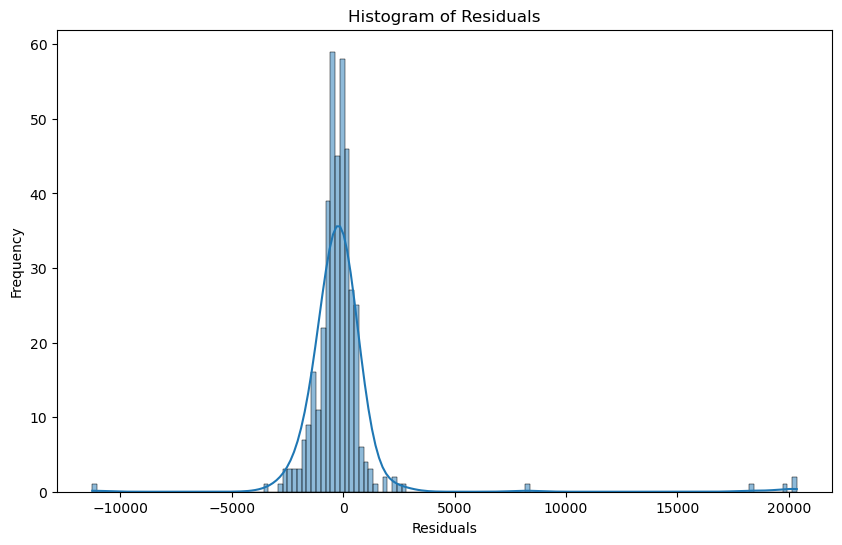

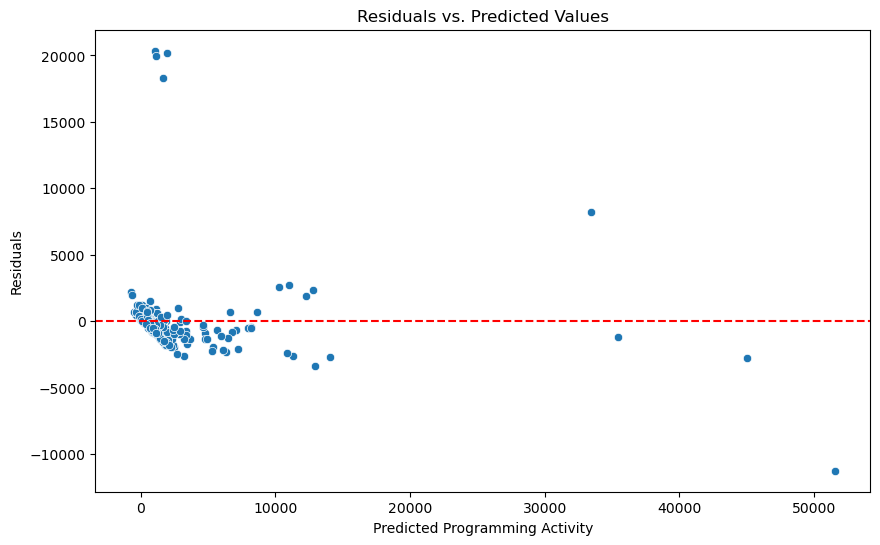

In [192]:
print("Descriptive Statistics of Residuals:\n", df_years_growth["residuals"].describe())

# Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(df_years_growth['residuals'], kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Residuals vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_years_growth['predicted'], y=df_years_growth['residuals'])
plt.axhline(0, color='red', linestyle='--')  # Adds a reference line at zero
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Programming Activity')
plt.ylabel('Residuals')
plt.show()


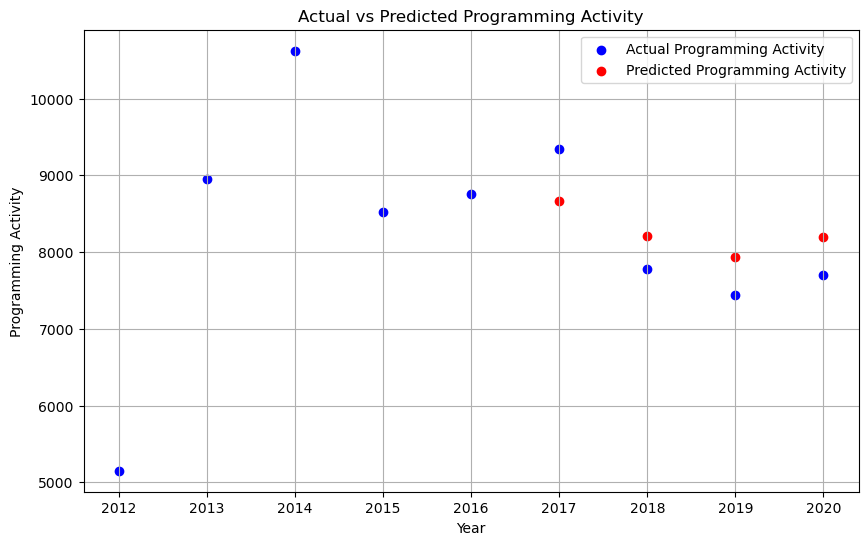

In [193]:
region = df_years_growth[df_years_growth["NUTS3"] == "TRÓJMIEJSKI"]
region_old = final_pl[(final_pl["NUTS3"] == "TRÓJMIEJSKI")]

# Plotting
plt.figure(figsize=(10, 6))

# Plot the actual programming density from the training data
plt.scatter(region_old['Year'], region_old['activity'], label='Actual Programming Activity', color='blue')

# Plot the predicted programming density for the next three years
plt.scatter(region['Year'], region['predicted'], label='Predicted Programming Activity', color='red')

# Customize the plot
plt.title('Actual vs Predicted Programming Activity')
plt.xlabel('Year')
plt.ylabel('Programming Activity')
plt.legend()
plt.grid(True)
plt.show()

## Analysis of Outliers in Poland 

In [ ]:
# Interpretation of residuals
interpretation = df_years_growth.new_residuals.apply(lambda x: 'Expected' if x == 0 else ('More' if x < 0 else 'Fewer'))

# Add the interpretation to the dataframe
df_years_growth['interpretation'] = interpretation

# Display a few rows of the dataframe with the new columns
df_years_growth[['NUTS3', 'activity', 'predicted_with_residuals', 'residuals', 'interpretation']]

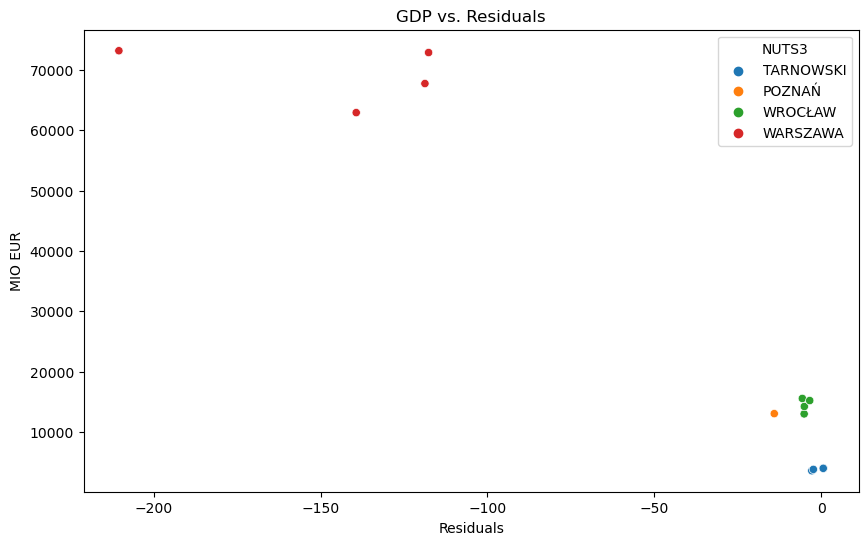

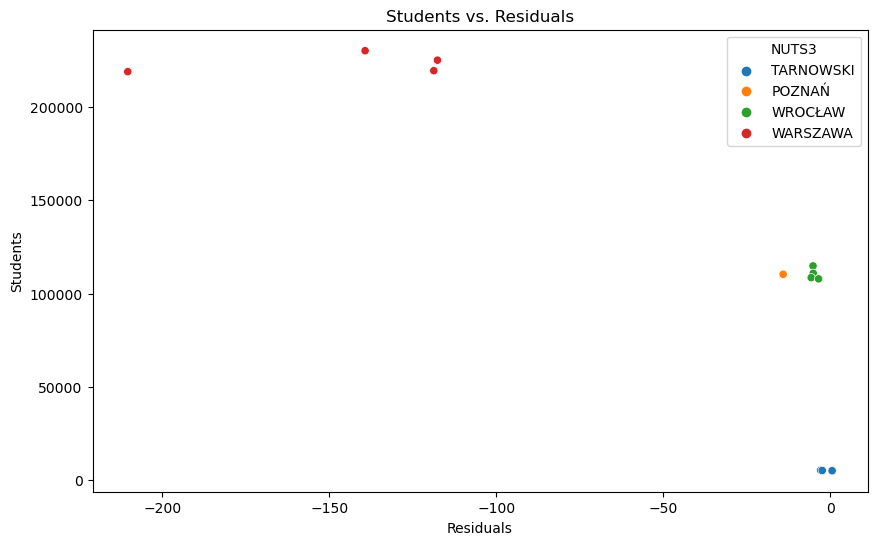

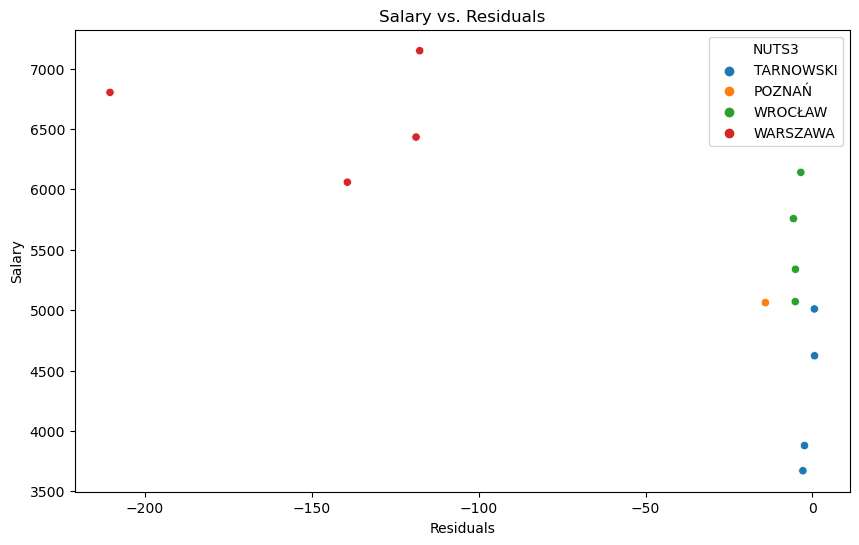

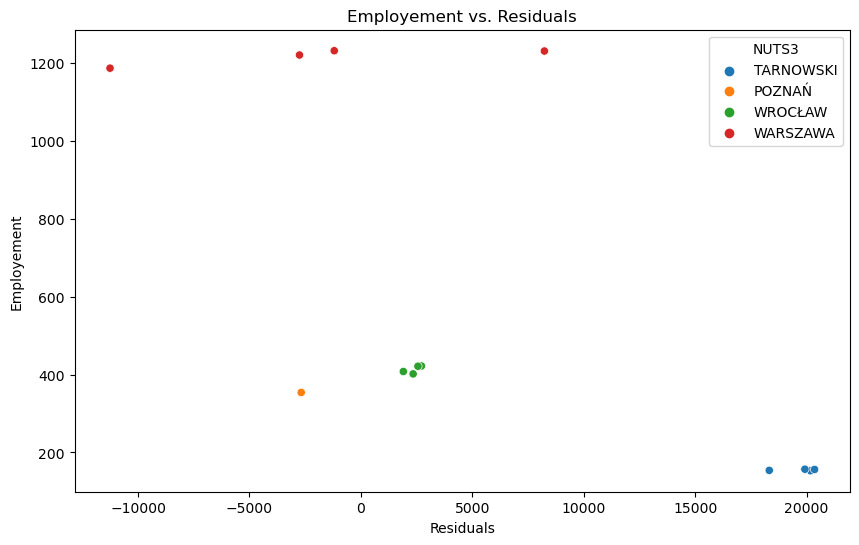

In [94]:
outliers = df_years_growth[(df_years_growth['new_residuals'] > 50) | (df_years_growth['new_residuals'] < -50) | (df_years_growth['predicted_with_residuals'] > 10000)]
outliers[["NUTS3", 'EMP (THS)', 'students', "MIO_EUR", "mean_salary" ,"activity", "predicted_with_residuals", "new_residuals", "interpretation", "population in cities in %", "Tech Universities"]]

# GDP vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=outliers['new_residuals'], y=outliers['MIO_EUR'], hue = outliers["NUTS3"])
plt.title('GDP vs. Residuals')
plt.xlabel('Residuals')
plt.ylabel('MIO EUR')
plt.show()

# Residuals vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=outliers['new_residuals'], y=outliers['students'], hue = outliers["NUTS3"])
plt.title('Students vs. Residuals')
plt.xlabel('Residuals')
plt.ylabel('Students')
plt.show()


# Residuals vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=outliers['new_residuals'], y=outliers['mean_salary'], hue = outliers["NUTS3"])
plt.title('Salary vs. Residuals')
plt.xlabel('Residuals')
plt.ylabel('Salary')
plt.show()

# Residuals vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=outliers['residuals'], y=outliers['EMP (THS)'], hue = outliers["NUTS3"])
plt.title('Employement vs. Residuals')
plt.xlabel('Residuals')
plt.ylabel('Employement')
plt.show()

The table presents data for regions that are outliers, significantly deviating from the rest of the observations. Let's analyze and interpret the results for each of these outlier regions:

**KRAKOWSKI:**

Activity: 2067.5
Predicted Activity: 452.33
Residuals: 1615.17 (More)
Interpretation: The region of KRAKOWSKI stands out as having significantly higher observed activity than predicted. This could be attributed to factors such as a employement and overall GDP of the region. Taking into consideration that this is a region around on of the biggest polish cities, many companies may have been established there and creating a lot of economical value that is interprated by model as a growht that boost programming activity, however the activity itself is located in the Krakow city. 


**SZCZECIN:**
Activity: 4715.0
Predicted Activity: 3254.80
Residuals: 1460.20 (Fewer)
Interpretation: SZCZECIN exhibits higher activity than predicted, possibly due to a flourishing tech community and the presence of tech universities contributing to a higher-than-expected programming activity.

**WROCŁAW:**
Activity: 13542.5
Predicted Activity: 11074.36
Residuals: 2468.14 (Fewer)
Interpretation: WROCŁAW stands out with significantly higher observed activity than predicted, suggesting a thriving tech ecosystem and a strong demand for programming skills in the region.


**ŁÓDŹ:**
Activity: 5436.0
Predicted Activity: 6675.79
Residuals: -1239.79 (Fewer)
Interpretation: ŁÓDŹ is an outlier with lower observed activity than predicted, suggesting a potentially less dynamic tech environment compared to the predicted values. Łódź has substantial number of tech universities that has driven the programming activity and which wasn't consdiered in the model itself, that's why the model understimated. 

**KIELECKI:**
Activity: 1016.0
Predicted Activity: 2060.63
Residuals: -1044.63 (Fewer)
Interpretation: KIELECKI exhibits lower observed activity than predicted, indicating a potential gap between the predicted and actual programming activity in the region. Due to the low economical factors the activity was underestimated, and number of students has a low priority for the model, hence the value predicted. Technical universities were not taken into consideration. 


**RZESZOWSKI:**
Activity: 2365.5
Predicted Activity: 3641.25
Residuals: -1275.75 (Fewer)
Interpretation: RZESZOWSKI exhibits lower observed activity than predicted, suggesting a potential mismatch between the predicted and actual programming activity in the region. Rzeszow has substantial number of tech universities that has driven the programming activity and which wasn't consdiered in the model itself, that's why the model understimated. 

**WARSZAWA:**
Activity: 39966.0
Predicted Activity: 39923.94
Residuals: 42.06 (More)
Interpretation: WARSZAWA is a slight outlier with slightly higher observed activity than predicted, indicating a robust tech sector and a thriving programming community. Extraordinary high every variable that we have caused the overestimating of programming acitivty, however with comparison with other cities, this residuals is not that high, meaning that taking into condieration the outstanding metrics, model was able to predict the value really good.

**PŁOCKI:**
Activity: 366.5
Predicted Activity: 2248.46
Residuals: -1881.96 (Fewer)
Interpretation: PŁOCKI stands out as an outlier with lower observed activity than predicted, potentially due to a less developed tech industry and due to a higher GDP and mean salary. This is a city located near capital of Poland - Warsaw, therefore many of the people who are working in Warsaw lives there and increase artificially a predicted activity. 

**TARNOWSKI:**
Activity: 19153.5
Predicted Activity: 1127.07
Residuals: 18026.43 (More)
Interpretation: TARNOWSKI is a noteworthy outlier with remarkably higher observed activity than predicted. This might be due to specific local conditions, such as a strong demand for programming skills, a dynamic tech sector, or unique regional characteristics. The region itself is not presenting a strong economical position with comparison to other regions, low GDP and low mean salary indicates that is not rather a technological hub, same goes with the number of tech universities that are low, as well as number of students. The data itself are not explaining high programming activity within this region, which is interesting and need further analysis. 

These outliers suggest variations in programming activity that may be influenced by unique regional factors, economic conditions, and the strength of the local tech ecosystem. Further investigation into each region's specific characteristics and local dynamics is recommended to gain a deeper understanding of these deviations.

## Tarnów Analysis

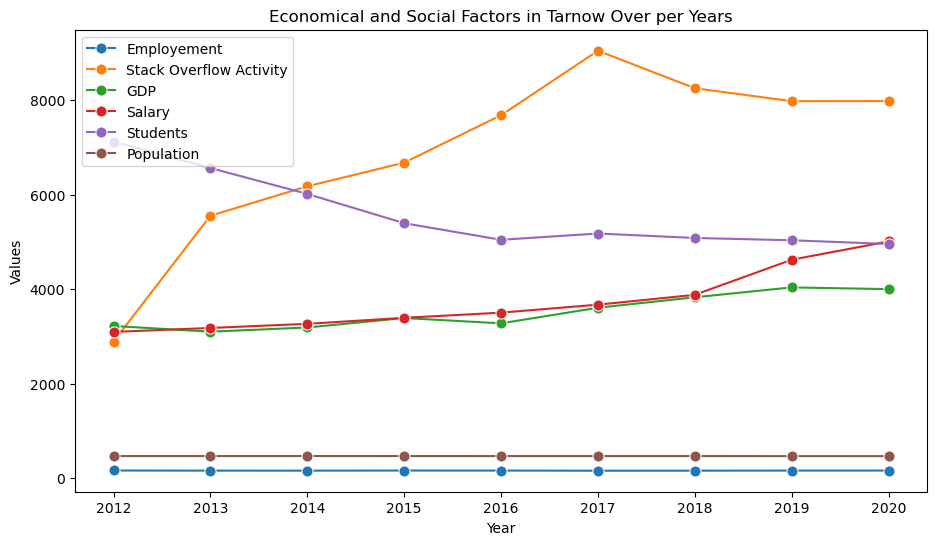

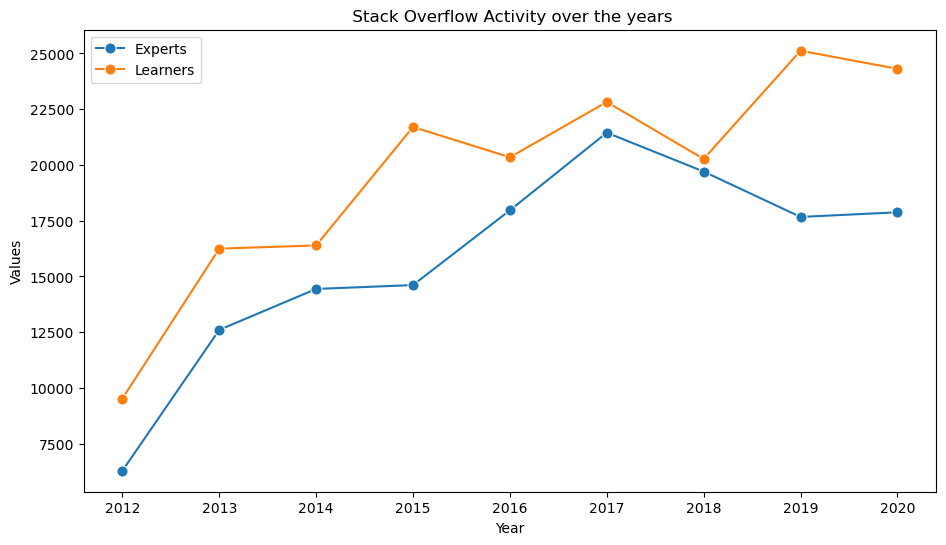

In [95]:
tarnow = final_pl[final_pl["NUTS3"] == "TARNOWSKI"]

plt.figure(figsize=(11, 6))
sns.lineplot(x='Year', y='EMP (THS)', data=tarnow, marker='o', markersize=8,  label='Employement')
sns.lineplot(x='Year', y="Programmers_Total", data=tarnow, marker='o', markersize=8, label='Stack Overflow Activity')
sns.lineplot(x='Year', y="MIO_EUR", data=tarnow, marker='o', markersize=8, label='GDP')
sns.lineplot(x='Year', y="mean_salary", data=tarnow, marker='o', markersize=8, label='Salary')
sns.lineplot(x='Year', y="students", data=tarnow, marker='o', markersize=8, label='Students')
sns.lineplot(x='Year', y="POP (THS)", data=tarnow, marker='o', markersize=8, label='Population')

plt.title('Economical and Social Factors in Tarnow Over per Years')
plt.xlabel('Year')
plt.ylabel('Values')
plt.legend()
plt.show()

plt.figure(figsize=(11, 6))
sns.lineplot(x='Year', y='questioncount', data=tarnow, marker='o', markersize=8,  label='Experts')
sns.lineplot(x='Year', y="answercount", data=tarnow, marker='o', markersize=8, label='Learners')
plt.title('GDP in Tarnow Over per Years')
plt.xlabel('Year')
plt.ylabel('Values')
plt.title(' Stack Overflow Activity over the years')
plt.legend()
plt.show()

In [96]:
tarnow.corr()["activity"]

Year                         0.874152
questioncount                0.959406
answercount                  0.965447
POP (THS)                   -0.667485
EMP (THS)                   -0.429015
EUR_HAB                      0.720849
EUR_HAB_EU27_2020            0.311476
MIO_EUR                      0.705825
MIO_NAC                      0.721609
MIO_PPS_EU27_2020            0.715208
PPS_EU27_2020_HAB            0.731229
PPS_HAB_EU27_2020            0.171740
GVA (MIO_EUR)                0.698751
GVA (MIO_NAC)                0.715891
mean_salary                  0.676205
students                    -0.955747
population in cities in %   -0.885932
Tech Universities                 NaN
Experts                      0.965447
Learners                     0.959406
Programmers_Total            0.985315
Programming_Density          0.985831
GDP_per_capita               0.706049
Programmer_Density_GDP       0.890155
EMPL_Rate                   -0.323582
Employed_Programmers         0.979701
activity    

In the case of Tarnow, the analysis shows that none of the analyzed metrics offers a clear correlation with its remarkably high programming activity. Despite stagnant population and employment figures over the years, coupled with a slow and marginal growth in salary and GDP – trends more reflective of the national landscape than the region itself – the justification for the surge in programming activity remains elusive. The absence of technical universities in the area and a declining number of students aren’t explaining the growth. The conventional markers of economic prosperity and educational infrastructure seem inadequate in explaining this anomaly. It beckons a more nuanced investigation into Tarnow's unique local conditions, potentially involving grassroots initiatives, industry-specific developments, or other unexplored facets that have catalyzed an unparalleled surge in programming activity. 